In [4]:
%%HTML
<style>
    body {
        --vscode-font-family: "Inter";
        font-size: 15px;``
    }
</style>

# **Dependencies**
* Pandas
* Plotly
* nbformat

# **Distance Running Predictions**

The objective of this project is to create a model that predicts race time given the distance and your history of running performance

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime

In [6]:
# import the dataset as a DataFrame
data = pd.read_csv("data/raw-data-kaggle.csv", delimiter=";")

data.head()

,athlete,gender,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm)
0,18042525,M,15/12/2019 09:08,2965.8,812,17.4,150.3
1,18042525,M,10/12/2019 19:27,10020.8,3290,52.2,160.8
2,18042525,M,03/12/2019 19:46,12132.2,4027,249.0,148.9
3,18042525,M,26/11/2019 19:46,11631.5,4442,194.0,136.2
4,18042525,M,19/11/2019 19:45,11708.1,4022,250.7,146.0


In [7]:
print(f'Number of unique athletes: {data["athlete"].nunique()}')
print(f'Number of genders: {data["gender"].nunique()}')
print(f"Precision of elevation gain: {data['elevation gain (m)'].apply(lambda x: len(str(x).split('.')[1]) if '.' in str(x) else 0).max()} m")

Number of unique athletes: 116
Number of genders: 2
Precision of elevation gain: 1 m


The raw data contains 42,116 data points. There are 7 variables in the data. 

Some observations:
* ```gender``` appears is boolean in nature (only either Male or Female)
* ```athlete``` is categorical data recorded as the numerical user ID. 
* Despite there being so many data points, there are only 116 different athletes - this means there is a lot of data per athlete.
* The other 5 columns are continuous numerical data. However, elevation gain is recorded as an integer.

# **Exploratory Data Analysis (EDA)**

The objectives of EDA are:
1. Confirm if the data is suitable for the application
1. Discover and resolve data quality issues (missing data, duplicates, incorrect values, anomalies, incorrect data types)
1. Check the data's mean, median, mode skewness, range, count etc.
1. Detect outliers and anomalies
1. Understand data patterns and correlations between variables

## **Data Cleaning**

### **Extracting Useful Columns**


I would like to make the running time predictions based solely on an individual's performance. Therefore, I will be excluding gender as a parameter for the model.

In [8]:
data = data.drop(columns = 'gender')

All the other columns should be useful and will be kept

### **Variable Formatting**

Here I'll check if every row of each column has the same data type, and if each column has the appropriate data type.

In [9]:
data.dtypes

athlete                       int64
timestamp                    object
distance (m)                float64
elapsed time (s)              int64
elevation gain (m)          float64
average heart rate (bpm)    float64
dtype: object

In [10]:
# convert timestamp to dtype datetime 
data["timestamp"] = pd.to_datetime(data["timestamp"])

C:\Users\hobly\AppData\Local\Temp\ipykernel_31200\3259052015.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data["timestamp"] = pd.to_datetime(data["timestamp"])


In [11]:
data.dtypes

athlete                              int64
timestamp                   datetime64[ns]
distance (m)                       float64
elapsed time (s)                     int64
elevation gain (m)                 float64
average heart rate (bpm)           float64
dtype: object

In [12]:
data.max()

athlete                                46817575
timestamp                   2020-01-06 05:24:00
distance (m)                           218950.0
elapsed time (s)                        2971531
elevation gain (m)                      12078.5
average heart rate (bpm)                  237.0
dtype: object

In [13]:
data.min()

athlete                                  771514
timestamp                   2000-01-04 12:06:00
distance (m)                                0.0
elapsed time (s)                              0
elevation gain (m)                          0.0
average heart rate (bpm)                    0.0
dtype: object

From looking at the minimum values, the distance, elapsed time and heart rate data have missing values that are not flagged as null.

### **Missing Values**

Let's check if there are null, nan or missing values anywhere

In [14]:
data.isnull().sum()

athlete                         0
timestamp                       0
distance (m)                    0
elapsed time (s)                0
elevation gain (m)              0
average heart rate (bpm)    18384
dtype: int64

In [15]:
print(f'Average number of rows per athlete: {data.shape[0]/data["athlete"].nunique():.2f}')
print(f'Percentage of rows that are missing heart rate: {23732/42116*100:.1f} %')

Average number of rows per athlete: 363.07
Percentage of rows that are missing heart rate: 56.3 %


From the above, we see that there are null values in the gender and heart rate columns. 

The more problematic column is average heart rate, which has a null value in the majority of its rows. <!-- While this would have been an extremely useful metric to infer athlete capability and race times, there is insufficient data to safely impute the missing values. Therefore, heart rate should be omitted as a variable in the model on the basis of insufficient data. -->

<!-- Let's not exclude heart rate just yet! Let's check the proportion of athletes with heart rate data entirely missing. If too many athletes are missing heart rate data entirely, it is not a useful metric. If each athlete has a proportionally small amount of heart rate data missing, we can impute it per-athlete, given the large amount of data per-athlete. -->

**Feature Engineering: Pace (minutes per km)**

Before I analyse heart rate, I'll create a new feature for each row: pace. This is the average speed of the run in units of minutes per kilometre. This will allow be to do further data analysis based on the average speed of the runs.

Pace will be used to analyse the data, but won't be used as an input or output for the models.

In [16]:
data["pace (min/km)"] = (data["elapsed time (s)"]/60)/(data["distance (m)"]/1000)

#### **Missing Data: Heart Rate**

In [17]:
# count the number of athletes that are entirely missing any heart rate data
allnull = data.groupby('athlete')['average heart rate (bpm)'].apply(lambda x: x.isnull().all()).sum()

print(f'There are {allnull} athletes that have no heart rate data at all.')

# count the number of rows with missing heart rate per athlete, as a proportion of their total number of rows
null_counts = data[data['average heart rate (bpm)'].isnull()].groupby('athlete').size()
row_per_athlete = data.groupby('athlete').size()
nullpc_per_athlete = null_counts/row_per_athlete

print(f'{(nullpc_per_athlete>0.4).sum()/len(nullpc_per_athlete)*100:.1f}% of athletes have no heart rate data in more than 40% of their recorded runs')

There are 10 athletes that have no heart rate data at all.
50.0% of athletes have no heart rate data in more than 40% of their recorded runs


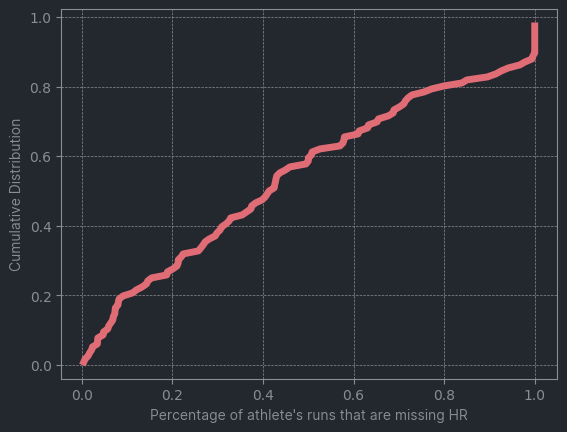

In [18]:
from helpers.my_plotting import my_cumulative

my_cumulative(nullpc_per_athlete, x_name="Percentage of athlete's runs that are missing HR")

##### **Discussion on Heart Rate**
Half of the athletes are missing HR data on >40% of their runs. There is insufficient data to impute the missing values. One option is to omit heart rate from the variables on which the models will be trained.

Alternatively, I could ignore the 56% of data that is missing heart rate, and only keep the remaining data. While I would be throwing away 56% of the data, there are still 26 thousand data points, which could be ample for my application. Heart rate is a very useful metric as it is the only objective variable in the dataset that indicates the level of effort exerted on a run.

On the basis of the importance of heart rate as a indicative parameter, I will choose to exclude all the data without heart rate.

In [19]:
data[data['average heart rate (bpm)'] == 0.0].size/len(data)*100

0.3988982809383607

In [20]:
data = data.dropna(subset=['average heart rate (bpm)']) # drop rows with missing heart rate
print(f"I've now got {data.shape[0]} data points")

I've now got 23732 data points


With the dropped rows, lets see how many runs each athelete has recorded.

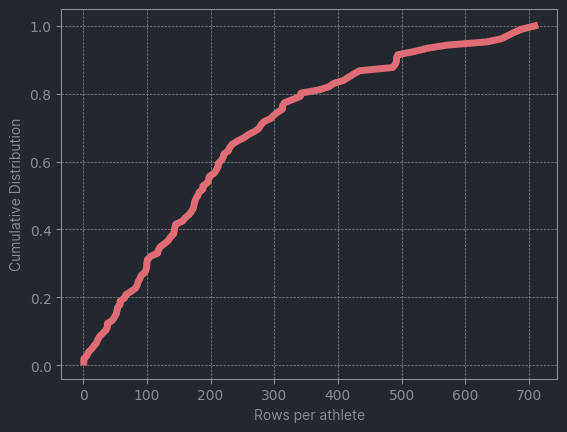

In [21]:
row_per_athlete = data.groupby('athlete').size()
my_cumulative(row_per_athlete, x_name="Rows per athlete")

70% of athletes have at least 100 data points. 

### **Drop Duplicates**

In [22]:
data = data.drop_duplicates()

print(f'There are now {data.shape[0]} rows that are unique')

There are now 23726 rows that are unique


## **Univariate Analysis**

### **Univariate Analysis: Heart Rate**

In [23]:
print(f"Number of rows with 0.0 BPM heart rate: {data[data['average heart rate (bpm)'] == 0.0].size}")
print(f"This is {data[data['average heart rate (bpm)'] == 0.0].size*100/data.shape[0]:.1f}% of the data")

Number of rows with 0.0 BPM heart rate: 168
This is 0.7% of the data


As a rule-of-thumb, I will impute if the missing data is more than 2% but less than 10%. Therefore I will not impute the missing data for heart rate = 0.0 BPM.

In [24]:
data.drop(data[data['average heart rate (bpm)'] == 0.0].index, inplace=True)
print(f"I've now got {data.shape[0]} data points with heart rate data")

I've now got 23702 data points with heart rate data


The world record for the slowest resting heart rate in a healthy human is 27 BPM. Therefore, runs with average heart rate below this value are practically impossible. While the average person would have a resting heart rate of 80 BPM, it is possible for athletes to have resting heart rates as low as 40 BPM.

In [25]:
data[data['average heart rate (bpm)']<40]

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km)
806,10825360,2019-12-30 09:34:00,17393.0,12745,807.0,36.9,12.212768
31292,12642956,2019-01-04 14:14:00,2471.0,9327,0.0,26.8,62.909753


The low heart rates above do not appear to be errors, as they are accompanied by extremely slow paces, but I will remove them as these paces will not be beneficial to the dataset. The upper end of the maximum heart rate is not implausible.

In [26]:
data.drop(data[data['average heart rate (bpm)']<40].index, inplace=True)
print(f"I've now got {data.shape[0]} data points")

I've now got 23700 data points


In [27]:
hr_sorted = np.sort(data['average heart rate (bpm)'].values)
hr_sorted[:10]

array([41.3, 44.7, 54.1, 54.9, 56.8, 57. , 57.1, 62. , 63.9, 64. ])

The lowest heart rates are still too low for running distances. To determine whether these must be removed, I must look at the data on a per-runner basis in the next step.

The highest heart rate ever recorded in a human is 600 BPM.

In [28]:
data[data['average heart rate (bpm)']>600]

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km)


There is no data that exceeds 600 BPM that I can delete on the basis of being implausible.

In [29]:
data["average heart rate (bpm)"].max()

237.0

The highest heart rate in my data is within reason.

#### **Graphical & Numerical Analysis**

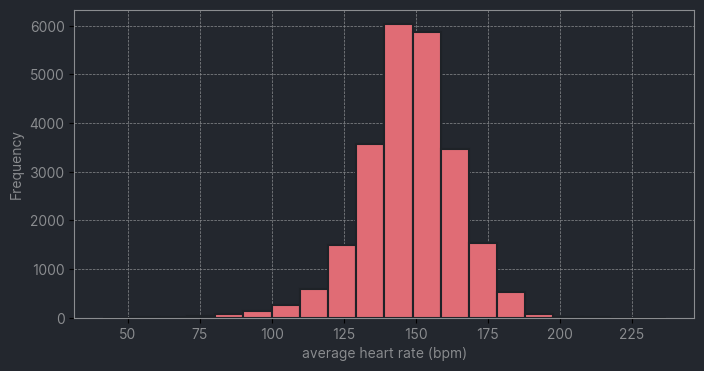

In [30]:
from helpers.my_plotting import my_freqdist

my_freqdist(data['average heart rate (bpm)'])

The data is slightly skewed to the right.

In [31]:
print("skewness: %f" % data['average heart rate (bpm)'].skew())
print("kurtosis: %f" % data['average heart rate (bpm)'].kurt())

skewness: -0.538677
kurtosis: 1.923665


In [32]:
from sklearn.preprocessing import StandardScaler

# standardise the data PER athlete
data['standardised_hr'] = data.groupby('athlete')['average heart rate (bpm)'].transform(lambda x: (x - x.mean()) / x.std())

# flag the row if hr standard deviation is too large
data['flag'] = (data['standardised_hr'] > 5.0) | (data['standardised_hr'] < -3)

data[(data['flag'] == True)]

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag
334,7191483,2019-01-06 09:02:00,13323.6,3817,134.7,62.0,4.774736,-6.352060,True
821,10825360,2019-11-21 18:10:00,11387.0,3665,160.0,104.6,5.364304,-4.703039,True
823,10825360,2019-11-17 08:41:00,1897.0,795,30.0,106.4,6.984713,-4.571985,True
845,10825360,2019-10-06 07:32:00,1788.0,667,5.0,118.3,6.217375,-3.705567,True
849,10825360,2019-10-05 05:39:00,1512.0,611,0.0,113.9,6.735009,-4.025923,True
...,...,...,...,...,...,...,...,...,...
41257,5035018,2019-01-17 10:32:00,19338.3,12720,1285.8,123.5,10.962701,-3.746396,True
41413,5035018,2018-02-13 19:08:00,1608.0,854,2.4,116.6,8.851575,-4.460997,True
41499,5035018,2017-08-15 19:11:00,1517.1,984,19.1,121.5,10.810098,-3.953527,True
41501,5035018,2017-08-15 17:42:00,1547.7,702,2.2,124.3,7.559605,-3.663544,True


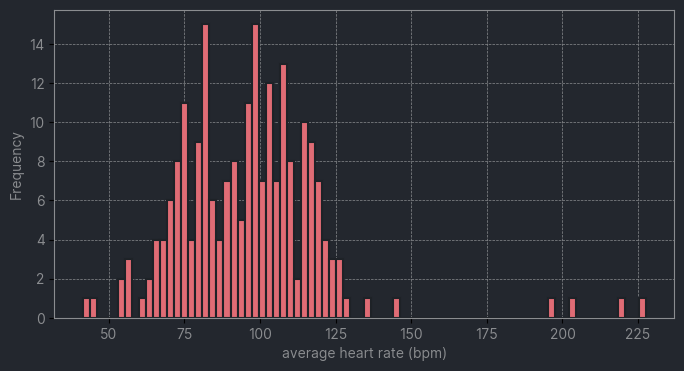

In [33]:
my_freqdist(data[(data['flag'] == True)]["average heart rate (bpm)"], n_bins=80)

Drop the rows that have an outlier heart rate, considering each athlete's individual mean heart rate.

In [34]:
data.drop(data[data['flag'] == True].index, inplace=True)
print(f"I've now got {data.shape[0]} data points")

I've now got 23481 data points


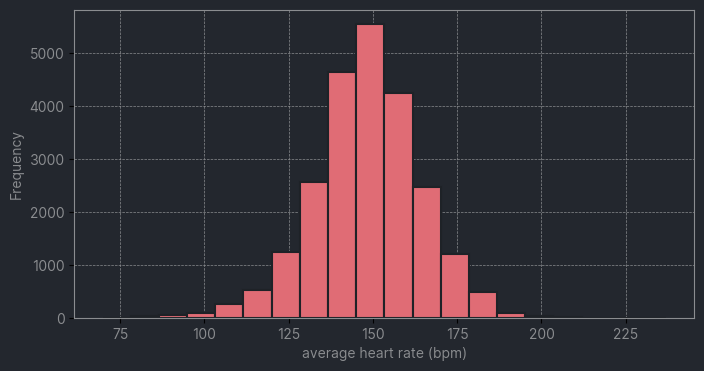

In [35]:
my_freqdist(data['average heart rate (bpm)'])

### **Univariate Analysis: Distance**

From the previous step, I know that no distance values are missing. Let's check if any distance values are 0.

In [36]:
data[data["elevation gain (m)"] == 0]

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag
114,18042525,2018-01-09 19:46:00,2126.2,726,0.0,123.0,5.690904,-1.630601,False
161,18042525,2017-05-04 16:09:00,9539.6,2972,0.0,143.4,5.192391,-0.026524,False
163,18042525,2017-04-27 16:37:00,6177.7,1679,0.0,158.0,4.529733,1.121492,False
167,18042525,2017-04-17 15:17:00,5160.3,1405,0.0,154.0,4.537850,0.806967,False
170,18042525,2017-03-31 16:49:00,5253.1,1419,0.0,158.7,4.502104,1.176534,False
...,...,...,...,...,...,...,...,...,...
41292,5035018,2018-11-14 18:47:00,447.5,204,0.0,151.3,7.597765,-0.867276,False
41304,5035018,2018-10-17 17:43:00,548.6,215,0.0,150.3,6.531778,-0.970842,False
41519,5035018,2017-07-02 08:36:00,1483.1,431,0.0,161.2,4.843459,0.158022,False
41559,5035018,2017-03-20 12:40:00,2725.1,803,0.0,161.9,4.911135,0.230517,False


In [37]:
print(f'There are {data[data["distance (m)"] == 0].shape[0]} rows without distance data')
print(f'All rows missing distance are also missing elevation: {np.all(data[data["distance (m)"] == 0] == data[(data["distance (m)"] == 0) & (data["elevation gain (m)"] == 0)])}')
data[(data["distance (m)"] == 0) & (data["elapsed time (s)"] < 10)]

There are 22 rows without distance data
All rows missing distance are also missing elevation: True


,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag
8032,6215611,2018-04-21 14:32:00,0.0,4,0.0,111.3,inf,-1.680656,False
13893,12740383,2019-12-18 06:38:00,0.0,2,0.0,119.0,inf,-1.868945,False
40981,5688059,2014-01-21 20:10:00,0.0,4,0.0,123.0,inf,-1.986620,False
40986,5688059,2014-01-15 19:42:00,0.0,4,0.0,114.0,inf,-2.644202,False


Many of the rows without distance also have unrealistically short elapsed time. All of the rows without distance are also missing elevation gain. As the rows missing distance are also missing other data, I'll delete them instead of imputing the missing data. This will prevent the creation of data points that are too artificial.

In [38]:
data.drop(data[data["distance (m)"] == 0.0].index, inplace=True)
print(f"I've now got {data.shape[0]} data points")

I've now got 23459 data points


**Remove sprint distances, too** - these could distort the model by creating a more complicated 'surface'

Above distances of 1500m (~1 mile), there is a significantly higher proportion of aerobic activity compared to shorter distances. Anecdotally, this is also the distance above which most non-runners cannot complete while running throughout. Therefore, I'll use this as our cut-off point. 

<[source](https://readysetmarathon.com/what-is-considered-distance-running/)>


In [39]:
data.drop(data[data["distance (m)"] < 1500].index, inplace=True)
print(f"I've now got {data.shape[0]} data points")

I've now got 23017 data points


In [40]:
print(f'Longest distance: {data["distance (m)"].max()}')
data[data["distance (m)"] == data["distance (m)"].max()]

Longest distance: 218950.0


,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag
16127,17639804,2018-10-18 19:59:00,218950.0,96372,9729.0,134.0,7.335921,-1.099759,False


The data row with the longest distance is implausible. The elapsed time is greater than a day, and the elevation gain is greater than Mount Everest. I'll go through time and elevation later on, so I'll leave this row in here for now.

### **Univariate Analysis: Elevation**

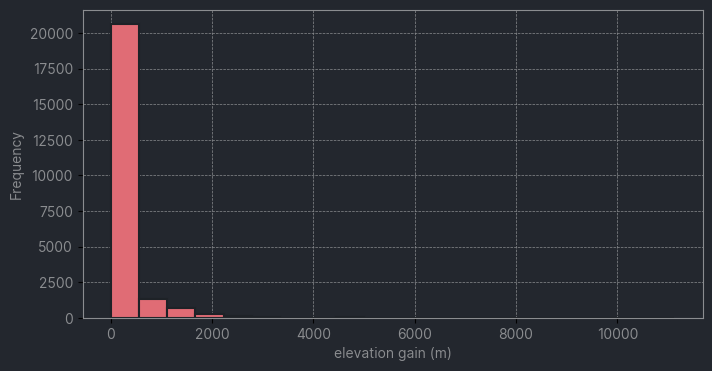

In [41]:
my_freqdist(data["elevation gain (m)"])

Elevation can't be eliminated on the basis of standard deviation. Outliers of elevation can still be perfectly valid. Therefore, I must eliminate based on what is actually possible and what is productive towards creating a good generalisable dataset.

In [42]:
print(f'Highest elevation gain: {data["elevation gain (m)"].max()} m')
print(f'{data[data["elevation gain (m)"] > 8849].shape[0]} rows with elevation gain higher than Mount Everest')

Highest elevation gain: 11128.0 m
2 rows with elevation gain higher than Mount Everest


The highest elevation gain in the data is 11,128 m. This is taller than Mount Everest, which is "only" 8,849 m high. I'll delete the row

In [43]:
data.drop(data[data["elevation gain (m)"] > 8849].index, inplace=True)

To assess whether a high elevation gain is valid, I'll do some **feature engineering** and construct a new feature: **gradient**, which is elevation divided by distance, expressed as a percentage.

In [44]:
data["gradient (%)"] = (data["elevation gain (m)"]/data["distance (m)"])*100
data[data["elevation gain (m)"] > 5000]

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag,gradient (%)
1031,10825360,2018-08-25 03:03:00,84278.0,52978,5450.0,157.5,10.476835,-0.851487,False,6.466694
13979,12740383,2019-06-28 02:00:00,90281.0,55226,5736.0,141.0,10.195205,-0.448842,False,6.353496
16161,17639804,2018-08-25 03:03:00,84149.3,47334,5245.0,146.4,9.375004,-0.104441,False,6.232969
40687,5688059,2016-05-06 03:08:00,126145.0,66815,7547.7,131.3,8.827804,-1.380183,False,5.983352


(<Figure size 600x400 with 1 Axes>,
 <Axes: xlabel='elevation gain (m)', ylabel='gradient (%)'>)

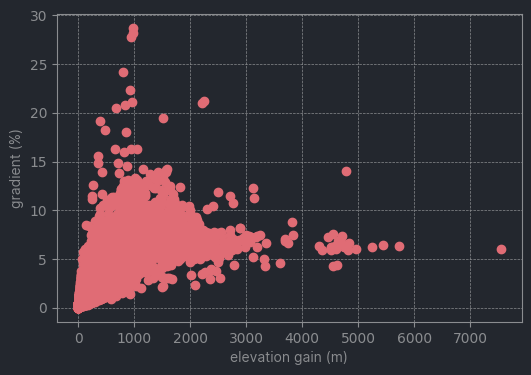

In [45]:
from helpers.my_plotting import my_xyscatter

my_xyscatter(data["elevation gain (m)"], data["gradient (%)"])

From the graphical analysis above, I can see that the data points with very high elevation gain also have fairly normal gradient. The data points with very high gradient do not have implausible elevation. Therefore, I don't have data to eliminate on the basis of high elevation.

In [46]:
data[data["elevation gain (m)"] == 0.0]

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag,gradient (%)
114,18042525,2018-01-09 19:46:00,2126.2,726,0.0,123.0,5.690904,-1.630601,False,0.0
161,18042525,2017-05-04 16:09:00,9539.6,2972,0.0,143.4,5.192391,-0.026524,False,0.0
163,18042525,2017-04-27 16:37:00,6177.7,1679,0.0,158.0,4.529733,1.121492,False,0.0
167,18042525,2017-04-17 15:17:00,5160.3,1405,0.0,154.0,4.537850,0.806967,False,0.0
170,18042525,2017-03-31 16:49:00,5253.1,1419,0.0,158.7,4.502104,1.176534,False,0.0
...,...,...,...,...,...,...,...,...,...,...
41098,5035018,2019-11-13 18:12:00,2801.0,624,0.0,151.7,3.712960,-0.825850,False,0.0
41137,5035018,2019-09-18 17:23:00,1843.0,709,0.0,155.8,6.411648,-0.401232,False,0.0
41284,5035018,2018-12-05 18:12:00,5087.7,1245,0.0,164.1,4.078464,0.458361,False,0.0
41559,5035018,2017-03-20 12:40:00,2725.1,803,0.0,161.9,4.911135,0.230517,False,0.0


In [47]:
print('There are {} rows with 0.0 elevation'.format(len(data[data["elevation gain (m)"] == 0.0])))

There are 1006 rows with 0.0 elevation


There is no way to tell if a data point with 0.0 elevation is truly invalid, so I won't delete any of these data points.

### **Univariate Analysis: Pace**

This is an engineered feature that indicates how fast an athlete was running on average.

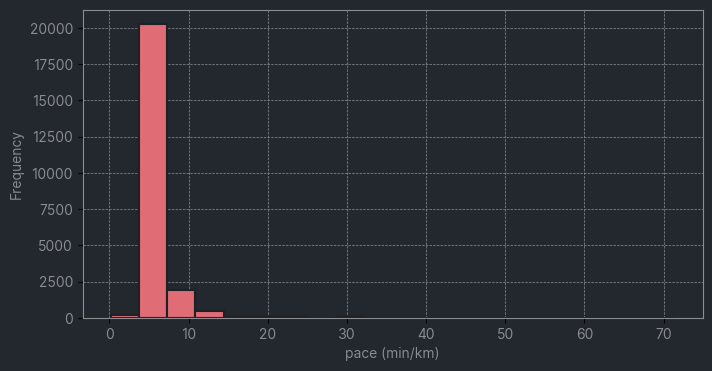

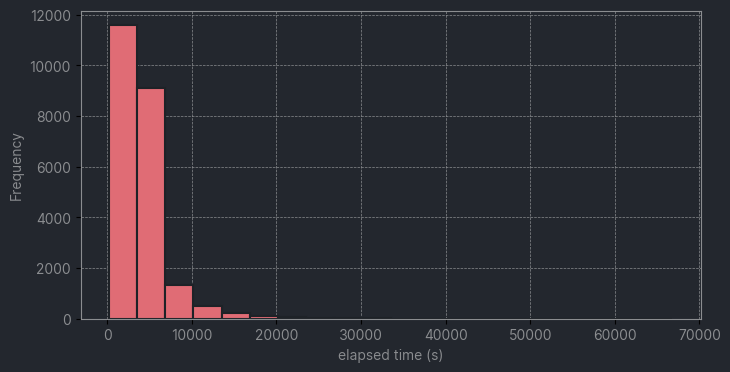

In [48]:
my_freqdist(data["pace (min/km)"])
my_freqdist(data["elapsed time (s)"])

Slow average pace are still valid and can still appear in the deployed incoming data, so I will leave these values in. However, I can eliminate paces that are impossibly fast as these are invalid.

In [49]:
print(f'Fastest pace {data["pace (min/km)"].min():.5f} min/km')
print(f'Slowest pace {data["pace (min/km)"].max():.5f} min/km')
print(f"World record 100m pace (Usain Bolt): {9.58/60/0.1:.5f} min/km")
print(f"World record 60m pace (Christian Coleman): {6.34/60/0.06:.5f} min/km")

Fastest pace 0.17581 min/km
Slowest pace 71.37915 min/km
World record 100m pace (Usain Bolt): 1.59667 min/km
World record 60m pace (Christian Coleman): 1.76111 min/km


In [50]:
print(f"Implausibly fast rows: {data[data['pace (min/km)'] < 1.59].size}")
print(f"Percentage of total: {data[data['pace (min/km)'] < 1.59].size/data.shape[0]*100:.2f} %")
data[data["pace (min/km)"] < 1.59]

Implausibly fast rows: 50
Percentage of total: 0.22 %


,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag,gradient (%)
11128,3460571,2019-05-26 07:09:00,33105.1,2752,935.6,144.4,1.385486,0.460520,False,2.826151
12261,2913078,2016-10-17 17:03:00,2130.7,189,0.0,127.8,1.478387,-0.630577,False,0.000000
13953,12740383,2019-08-23 23:22:00,41746.6,2001,2513.0,123.6,0.798867,-1.572014,False,6.019652
19643,18736169,2019-02-05 16:59:00,10683.0,399,47.6,135.3,0.622484,-0.793141,False,0.445568
37941,22891135,2018-06-23 04:31:00,36593.1,386,347.4,144.7,0.175807,-0.394992,False,0.949359


As before, I stated that I would impute data if the affected rows were more than 2% but less than 10%. Therefore, I will delete these data points instead of imputing them.

In [51]:
data.drop(data[data["pace (min/km)"] < 1.59].index, inplace=True)

I can also delete paces that exceed the world record pace for long distances. For each race distance, I'll delete rows that have both a distance greater than that distance and a time shorter than the world record time for that distance.

In [52]:
fastest_distances = {
    '50k':
        {
            'time': 2*3600+40*60+13, 
            'distance': 50000
        },
    'marathon': 
        {
            'time': 2*3600+35, 
            'distance': 42195
        }, 
    'half': 
        {
            'time': 57*60+31, 
            'distance': 42195/2
        }, 
    '15k': 
        {
            'time': 44*60+14, 
            'distance': 15000
        }, 
    '12k': 
        {
            'time': 35*60+57, 
            'distance': 12000
        }, 
    '10k': 
        {
            'time': 26*60+11, 
            'distance': 10000
        }, 
    '8k': 
        {
            'time': 22*60+39, 
            'distance': 8000
        }, 
    '5k': 
        {
            'time': 13*60+38, 
            'distance': 5000
        }, 
    '1500m': 
        {
            'time': 3*60+26, 
            'distance': 1500
        }
    }

In [53]:
def valid_pace(row):

    for field in fastest_distances:
        if ((row['distance (m)'] > fastest_distances[field]['distance']) & (row['elapsed time (s)'] < fastest_distances[field]['time'])):
            return True

data["flag"] = data.apply(valid_pace, axis=1)
data[data["flag"]==True]

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag,gradient (%)
6716,7947798,2015-11-18 18:36:00,1868.8,202,0.0,157.7,1.801513,1.802741,True,0.000000
12194,2913078,2017-02-04 16:24:00,1579.7,184,0.0,91.9,1.941297,-2.253710,True,0.000000
19644,18736169,2019-02-04 17:45:00,15906.0,1914,211.9,126.8,2.005533,-1.324577,True,1.332202
29568,2138770,2018-10-16 11:38:00,43630.2,6673,453.2,139.3,2.549075,-0.420376,True,1.038730
29580,2138770,2018-09-03 14:52:00,67299.7,7953,584.0,134.6,1.969548,-0.712452,True,0.867760
31278,12642956,2019-01-27 08:07:00,15070.0,1926,159.0,164.3,2.130060,0.487835,True,1.055076
31808,11284478,2017-05-26 06:30:00,22841.0,2537,1175.0,163.3,1.851203,0.832833,True,5.144258


In [54]:
data.drop(data[data['flag'] == True].index, inplace=True)

### **Univariate Analysis: Timestamp**

I'll do more feature engineering and construct another feature that indicates the time since the data point was performed. This is because runs that are more recent will be more indicative of future performance.

In [55]:
# Calculate the amount of time since that run - the datum doesn't matter 

data["time ago (s)"] = datetime(2023, 1, 1) - data["timestamp"]

data["time ago (s)"] = data["time ago (s)"].apply(lambda x: x.total_seconds())

data.head()

,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag,gradient (%),time ago (s)
0,18042525,2019-12-15 09:08:00,2965.8,812,17.4,150.3,4.563131,0.516032,None,0.586688,96130320.0
1,18042525,2019-12-10 19:27:00,10020.8,3290,52.2,160.8,5.471952,1.341660,None,0.520916,96525180.0
2,18042525,2019-12-03 19:46:00,12132.2,4027,249.0,148.9,5.532110,0.405948,None,2.052390,97128840.0
3,18042525,2019-11-26 19:46:00,11631.5,4442,194.0,136.2,6.364900,-0.592669,None,1.667885,97733640.0
4,18042525,2019-11-19 19:45:00,11708.1,4022,250.7,146.0,5.725381,0.177917,None,2.141253,98338500.0


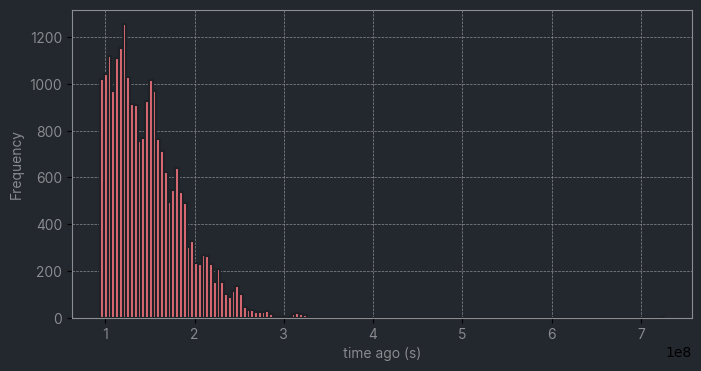

In [56]:
my_freqdist(data["time ago (s)"],n_bins=150)

In [57]:
print(f'Newest data point: {max(data["timestamp"])}')
print(f'Oldest data point: {min(data["timestamp"])}')

Newest data point: 2020-01-06 05:24:00
Oldest data point: 2000-01-04 12:06:00


The timestamp column has no problems.

## **Feature Scaling**

### **Frequency Distributions & Transformation**

In [58]:
from sklearn.preprocessing import PowerTransformer
from scipy.stats import yeojohnson

#### **Elevation**

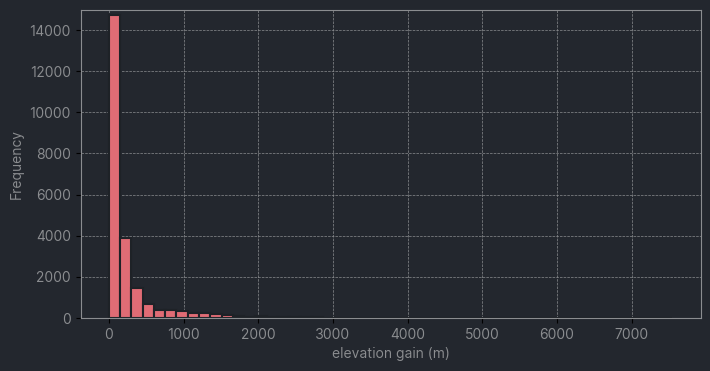

Skewness: 4.31
Kurtosis: 29.22


In [59]:
x = data["elevation gain (m)"]

my_freqdist(x,n_bins=50, ylim=[0,15000])

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

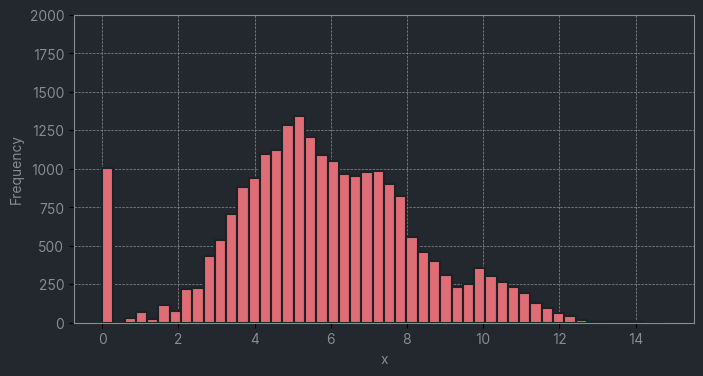

Skewness: 0.01
Kurtosis: 0.23


In [60]:
from scipy.stats import boxcox

x = boxcox(data["elevation gain (m)"]+1)[0]

my_freqdist(x,n_bins=50, ylim=[0,2000])

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

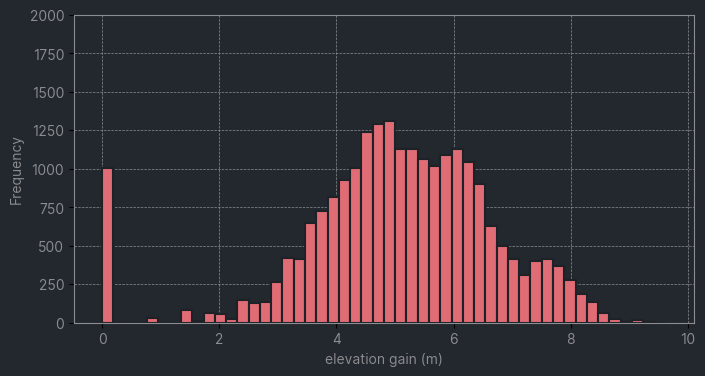

Skewness: -0.84
Kurtosis: 1.46


In [61]:
x = np.arcsinh(data["elevation gain (m)"])

my_freqdist(x,n_bins=50, ylim=[0,2000])

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

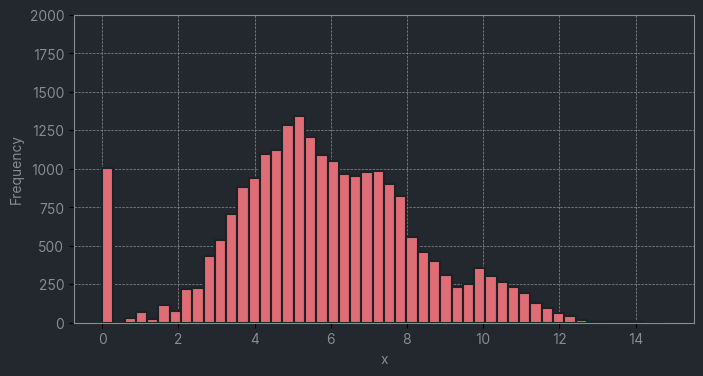

Skewness: 0.01
Kurtosis: 0.23


In [62]:
x = yeojohnson(data["elevation gain (m)"])[0]

my_freqdist(x,n_bins=50, ylim=[0,2000])

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

I will use Yeo-Johnson to scale Elevation

In [63]:
data["elevation"] = yeojohnson(data["elevation gain (m)"])[0]

#### **Distance**

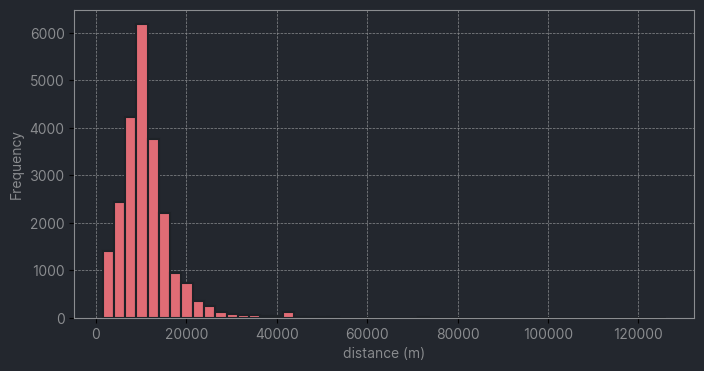

Skewness: 3.39
Kurtosis: 26.19


In [64]:
x = data['distance (m)']

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

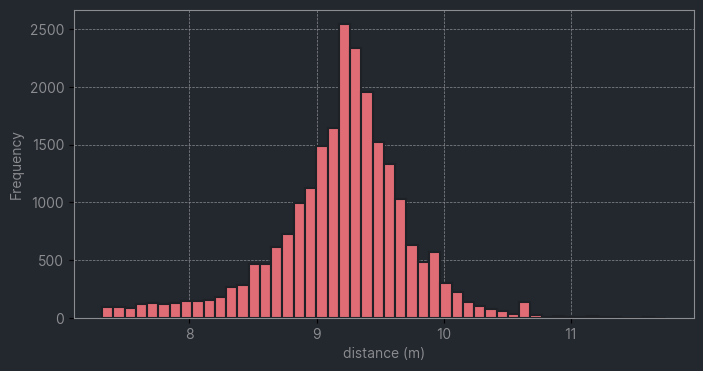

Skewness: -0.56
Kurtosis: 1.73


In [65]:
x = np.log(data["distance (m)"])

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

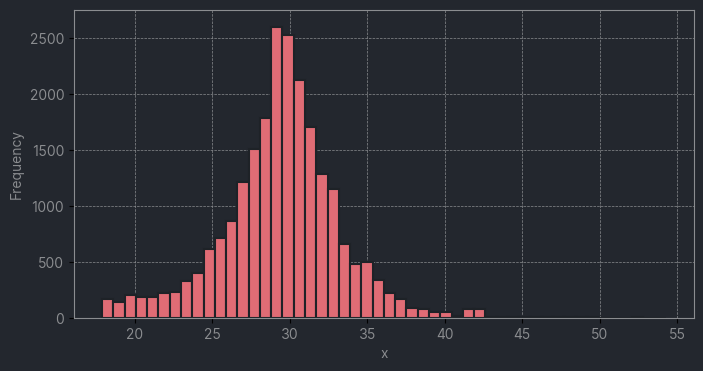

Skewness: 0.07
Kurtosis: 1.90


In [66]:
x = boxcox(data["distance (m)"])[0]

my_freqdist(x,n_bins=50, ylim=[0,2750])

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

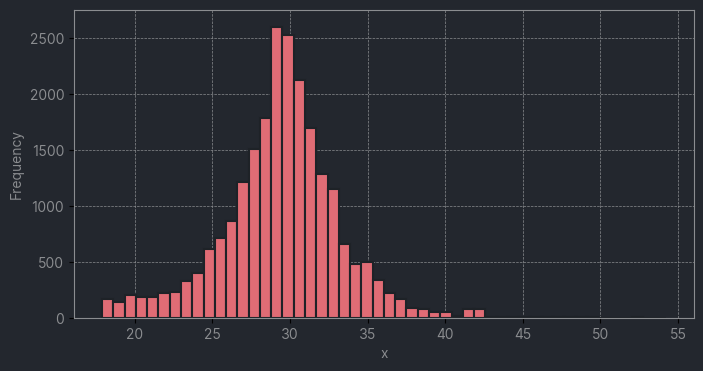

Skewness: 0.07
Kurtosis: 1.90


In [67]:
x = yeojohnson(data["distance (m)"])[0]

my_freqdist(x,n_bins=50, ylim=[0,2750])

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

I will use Yeo-Johnson to scale Distance.

In [68]:
data["distance"] = yeojohnson(data["distance (m)"])[0]

#### **Heart Rate**

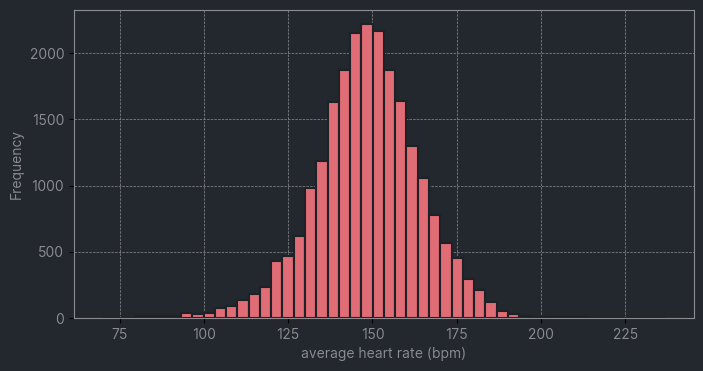

Skewness: -0.22
Kurtosis: 0.94


In [69]:
x = data['average heart rate (bpm)']

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

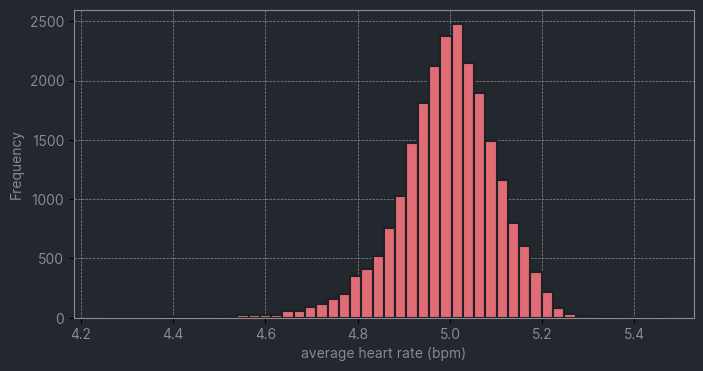

Skewness: -0.74
Kurtosis: 2.11


In [70]:
x = np.log(data['average heart rate (bpm)'])

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

Heart Rate does not need to be transformed as it is already highly normally distributed.

In [71]:
data["hr"] = data['average heart rate (bpm)']

#### **Time Ago**

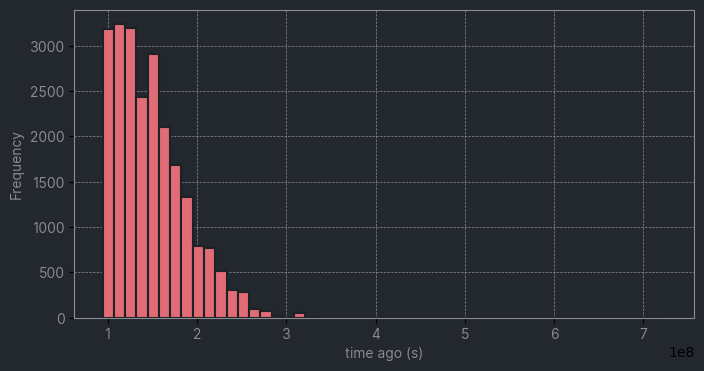

Skewness: 1.09
Kurtosis: 2.67


In [72]:
x = data["time ago (s)"]

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

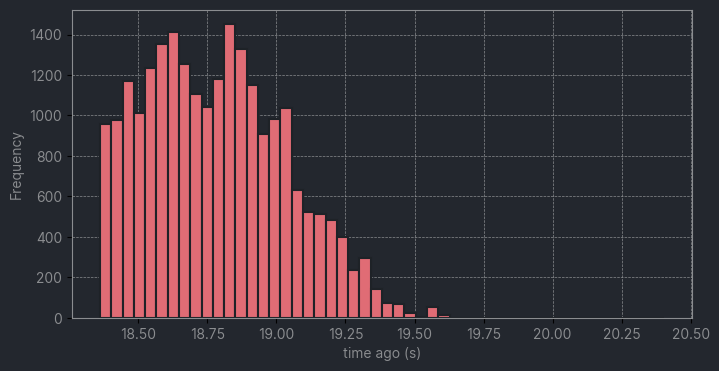

Skewness: 0.41
Kurtosis: -0.44


In [73]:
x = np.log(data["time ago (s)"])

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

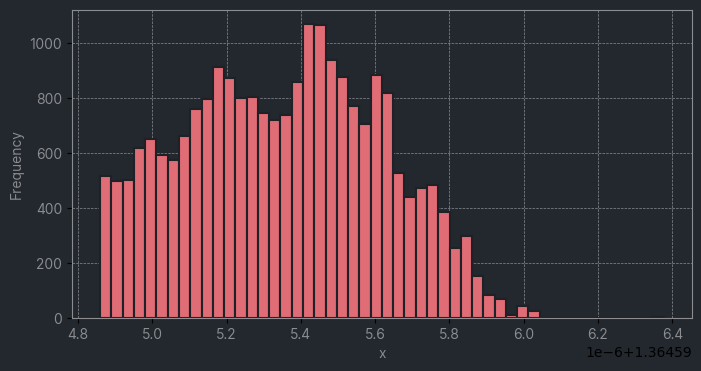

Skewness: 0.00
Kurtosis: -0.84


In [74]:
x = boxcox(data["time ago (s)"])[0]

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

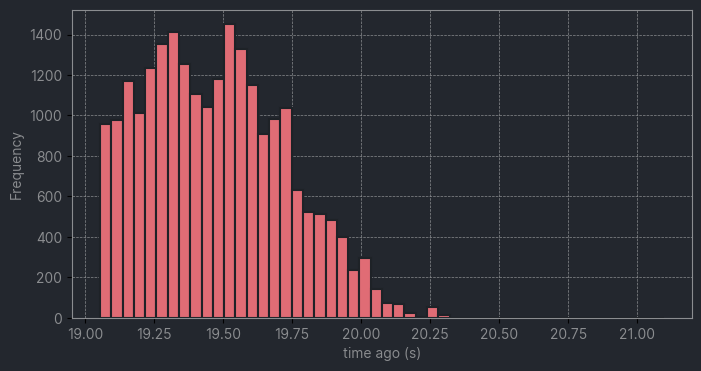

Skewness: 0.41
Kurtosis: -0.44


In [75]:
x = np.arcsinh(data["time ago (s)"])

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

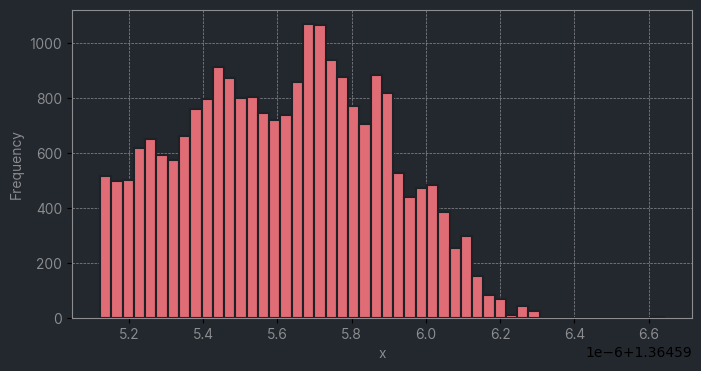

Skewness: 0.00
Kurtosis: -0.84


In [76]:
x = yeojohnson(data["time ago (s)"])[0]

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

I will also use Yeo-Johnson to scale Time-Ago

In [77]:
data["time_ago"] = yeojohnson(data["time ago (s)"])[0]

#### **Time**

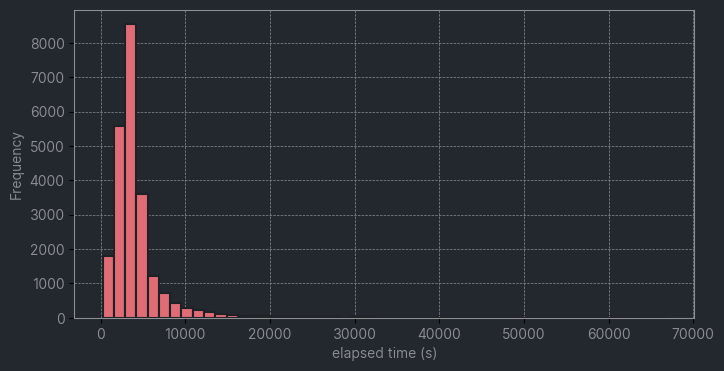

Skewness: 5.08
Kurtosis: 46.11


In [78]:
x = data["elapsed time (s)"]

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

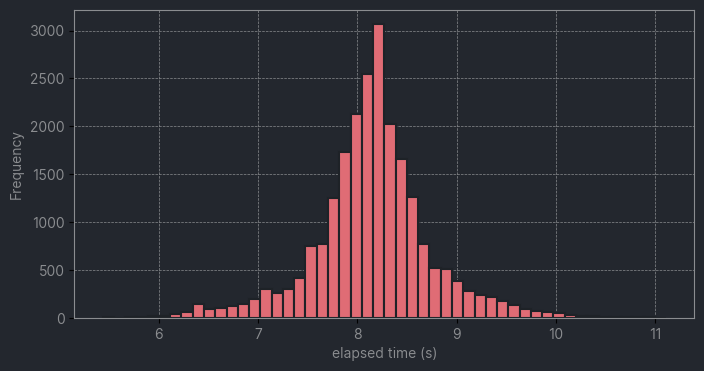

Skewness: -0.04
Kurtosis: 2.07


In [79]:
x = np.log(data["elapsed time (s)"])

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

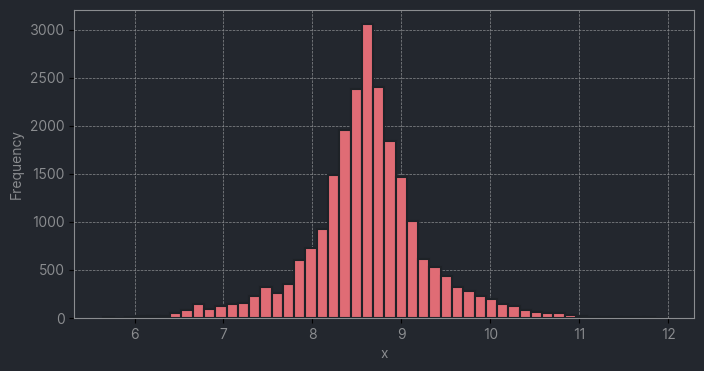

Skewness: 0.01
Kurtosis: 2.08


In [80]:
x = yeojohnson(data["elapsed time (s)"])[0]

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

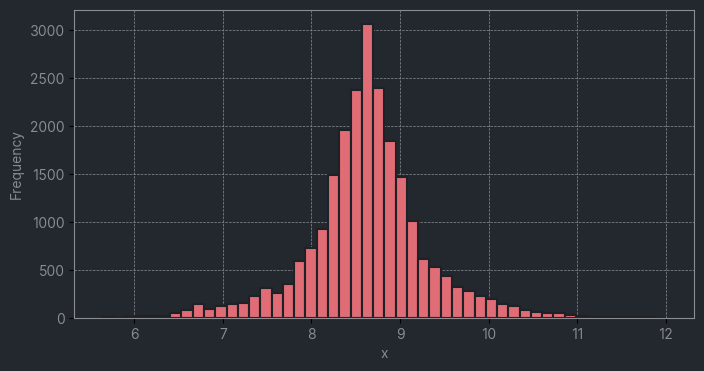

Skewness: 0.01
Kurtosis: 2.08


In [81]:
x = boxcox(data["elapsed time (s)"])[0]

my_freqdist(x,n_bins=50)

skewness = pd.Series(x).skew()
kurtosis = pd.Series(x).kurtosis()
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurtosis:.2f}")

Yeo-Johnson and BoxCox perform identically. For consistency's sake, I'll use Yeo-Johnson to scale Time.

### **Summary of Transformations and Variables**

| **Variable** | **Type** | **Transform** |
|--------------|----------|---------------|
| Distance     | Input    | Yeo-Johnson    |
| Elevation    | Input    | Yeo-Johnson    |
| HR           | Input    | None           |
| Time-Ago     | Input    | Yeo-Johnson    |
| Time         | Output   | Yeo-Johnson    |


### **Scaling**

In [82]:
from sklearn.preprocessing import MinMaxScaler

## **Pre-Visualising the Relationshing**

Let's plot 3 variables against each other as the 3D space will allow us to easily visualise the correlations.

In [83]:
from helpers.my_plotting import my_scatter

athletes = data["athlete"].unique()
athlete_idx = 6

my_scatter(x=data.loc[data["athlete"] == athletes[athlete_idx]]["average heart rate (bpm)"],
           y=data.loc[data["athlete"] == athletes[athlete_idx]]["distance (m)"],
           z=data.loc[data["athlete"] == athletes[athlete_idx]]["elapsed time (s)"],
           c=data.loc[data["athlete"] == athletes[athlete_idx]]["time ago (s)"],
           height=600)

In [84]:
my_scatter(x=data.loc[data["athlete"] == athletes[athlete_idx]]["average heart rate (bpm)"],
           y=data.loc[data["athlete"] == athletes[athlete_idx]]["distance (m)"],
           z=data.loc[data["athlete"] == athletes[athlete_idx]]["pace (min/km)"],
           c=data.loc[data["athlete"] == athletes[athlete_idx]]["gradient (%)"],
           height=600)

Plotting Pace instead of Time shows that Time is a much more predictable variable to correlate, and that I was correct in using Time as a predictor instead of Pace.

Now that the data is processed and normalised, I'll create an initial Neural Network (NN) to see the minimum number of nodes to capture the input/output map with at least 90% accuracy for a given user. This will allow me to decide whether a helper model for fine-tuning is feasible.

The possible outcomes will be:
* Low number of nodes: the output of the helper fine-tuning model can be the changes to weights and biases for each node
* High number of nodes: there are too many weights and biases to create a neural network with these as outputs - I'll have to fine tune base models directly, and probably use a greater number of clusters 
* Accuracy can't be captured with 90% accuracy: this indicates that there is poor correlation of the input with the output

## **EDA Conclusion**

The EDA has now been completed. The data is cleaned, transformed and scaled.

In [85]:
data.to_csv("cleaned_data.csv", index_label='index')

In [86]:
data = pd.read_csv("cleaned_data.csv", index_col='index')

# **Model Strategy**

Each athlete has 1 model etc.

# **Train-Test Split**

I will split my data not randomly, but according to how much many runs each athlete has. The athletes with too few runs to be useful will be used for testing.

don't transform entire datasets. Transform for each base model

In [87]:
len(data["athlete"].unique())

106

In [88]:
athlete_counts = data['athlete'].value_counts()
data['row_count'] = data['athlete'].map(athlete_counts)
print(f"There are {data.drop_duplicates(subset='athlete').sort_values(by='row_count')[data['row_count']<30].shape[0]} athletes with fewer than 30 data points")


There are 10 athletes with fewer than 30 data points


C:\Users\hobly\AppData\Local\Temp\ipykernel_31200\2565965533.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [89]:
data.drop_duplicates(subset='athlete')[['athlete', 'row_count']].sort_values(by='row_count').head(10)

,athlete,row_count
index,,
38422,25277048,1
37284,20557028,1
29069,28252317,6
36933,38870390,8
280,20263706,13
7119,22972731,17
19328,39076296,20
12938,27479582,22
38504,6583234,23


In [90]:
ath_mostruns = data.drop_duplicates(subset='athlete')[data["row_count"]==data["row_count"].max()]["athlete"].values[0]

data[data["athlete"]==ath_mostruns].sort_values(by='average heart rate (bpm)', ascending=False)


C:\Users\hobly\AppData\Local\Temp\ipykernel_31200\2129297842.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,athlete,timestamp,distance (m),elapsed time (s),elevation gain (m),average heart rate (bpm),pace (min/km),standardised_hr,flag,gradient (%),time ago (s),elevation,distance,hr,time_ago,row_count
index,,,,,,,,,,,,,,,,
39389,19023831,2019-01-18 05:16:00,8431.5,2506,18.7,188.4,4.953646,4.199279,NaN,0.221787,124742640.0,3.499298,28.112991,188.4,1.364595,689
39607,19023831,2018-03-21 08:23:00,8534.5,2520,100.8,187.0,4.921202,4.082550,NaN,1.181089,150910620.0,5.949740,28.199210,187.0,1.364596,689
39714,19023831,2017-10-02 03:42:00,8997.4,3026,67.6,184.9,5.605323,3.907456,NaN,0.751328,165615480.0,5.321720,28.576920,184.9,1.364596,689
39516,19023831,2018-07-25 05:35:00,6863.5,2303,47.0,182.0,5.592385,3.665661,NaN,0.684782,140034300.0,4.775544,26.685934,182.0,1.364596,689
39202,19023831,2019-10-24 04:26:00,10314.4,3055,38.0,179.7,4.936464,3.473892,NaN,0.368417,100640040.0,4.467239,29.574088,179.7,1.364595,689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39652,19023831,2018-01-07 10:10:00,4010.0,1145,14.7,110.2,4.758936,-2.320867,NaN,0.366584,157211400.0,3.192680,23.245431,110.2,1.364596,689
39598,19023831,2018-04-07 08:23:00,5038.9,1359,21.4,109.4,4.495029,-2.387569,NaN,0.424696,149441820.0,3.676085,24.658745,109.4,1.364596,689
39513,19023831,2018-07-29 08:03:00,2029.6,962,9.7,107.1,7.899750,-2.579338,NaN,0.477927,139679820.0,2.690989,19.424414,107.1,1.364596,689


In [91]:
race_idx_19023831 = 39202 # index in data df for a race by athlete 19023831

In [92]:
from helpers.my_plotting import my_iteractable_cumulative

my_iteractable_cumulative(data["row_count"].drop_duplicates())

In [93]:
train_athletes = data[data["row_count"]>=200].sort_values("row_count", ascending=False)["athlete"].drop_duplicates().values.tolist()

print(f'{len(train_athletes)} athletes will be used to train models')

test_athletes = data[data["row_count"]<200].sort_values("row_count", ascending=False)["athlete"].drop_duplicates().values.tolist()

print(f'{len(test_athletes)} athletes will be used to test models')

46 athletes will be used to train models
60 athletes will be used to test models


I want to avoid activation functions such as Sigmoid, Softmax, ReLU and Tanh, especially in the output layer, as these have a fixed maximum and minimum. This is because it is very possible that data could be received that is outside the range of the original train set.

In [94]:
from helpers.distance_running import LeakyReLU_NN, athlete_data
from helpers.distance_running import INPUT_COLS as INPUT_COLS

INPUT_COLS

['distance (m)',
 'elevation gain (m)',
 'average heart rate (bpm)',
 'time ago (s)']

In [95]:
data19023831 = athlete_data(athletes = [ath_mostruns], race_idx = race_idx_19023831, device = "cpu")

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:104: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)



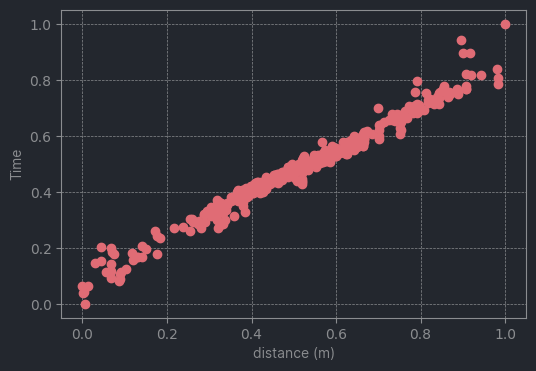

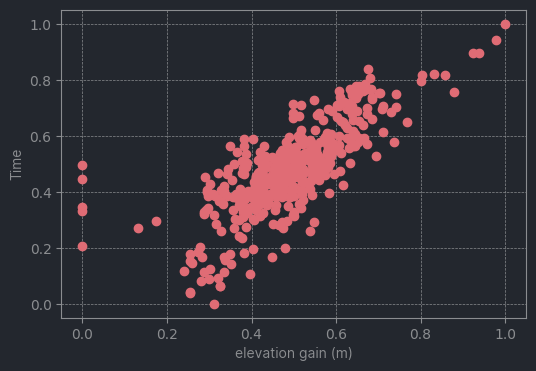

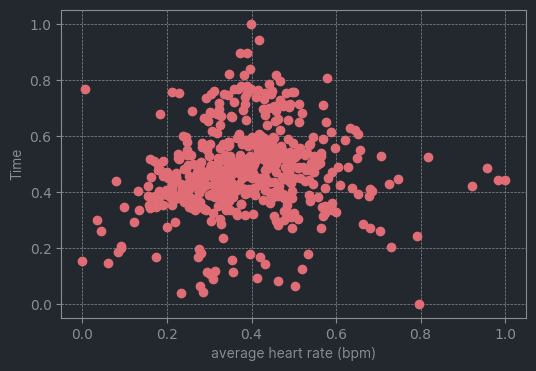

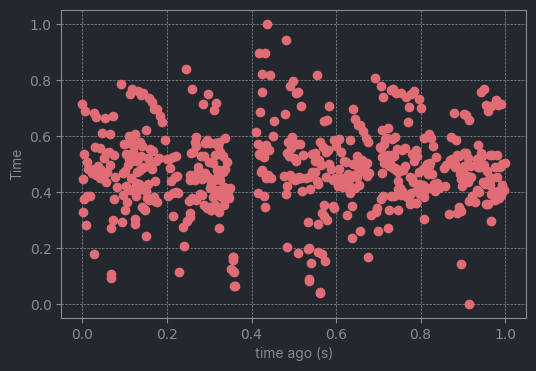

In [96]:
for k in range(len(INPUT_COLS)):
    my_xyscatter(data19023831.x_train_vals[:,k], data19023831.y_train_vals.reshape(-1),
                x_name=INPUT_COLS[k], y_name='Time')

The above graphs show that time_ago and HR are poor indicators of the time variable. Therefore, I'll check if pace is a better y variable than time. HR should better indicate pace, but time_ago will likely still be poorly correlated. Therefore, this value should either be dropped as an input variable, or an RNN/LSTM should be used to capture the passage of time between runs.

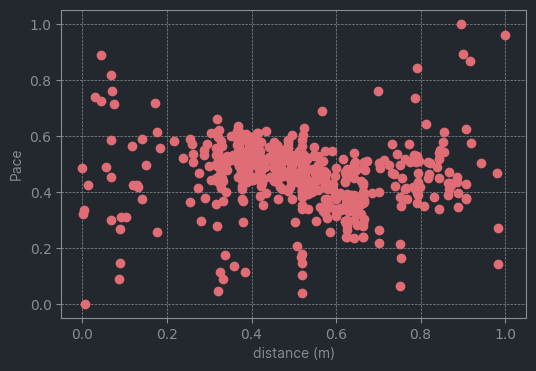

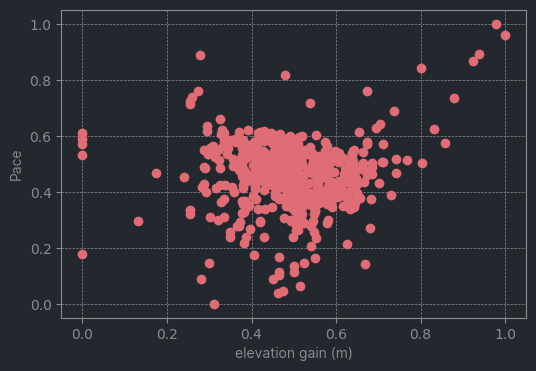

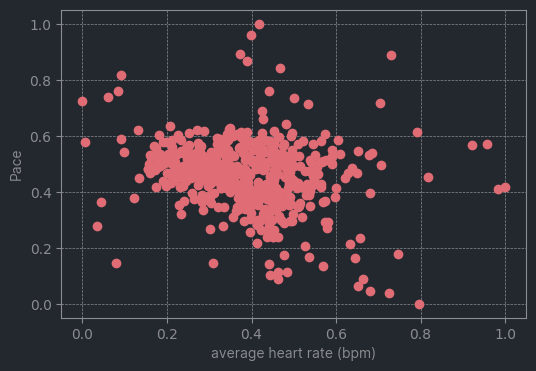

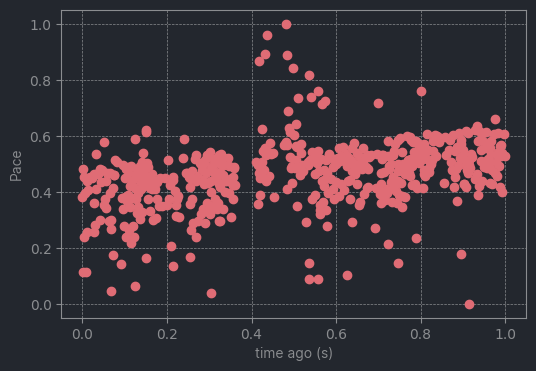

In [97]:
for k in range(len(INPUT_COLS)):
    my_xyscatter(data19023831.x_train_vals[:,k], data19023831.pace_scaled.reshape(-1),
                x_name=INPUT_COLS[k], y_name='Pace')

In [98]:
from helpers.distance_running import mape_actualtime, model_handler, find_hn_epochs

To optimise the number of hidden nodes and epochs, I want to use MAPE as the evaluation metric. The models will still be trained with MSE as the loss criterion. 

The code below identifies the number of hidden nodes that achieves the lowest MAPE loss across the full range of epochs between 1 and 500. I will then select the combination of hidden nodes and epochs that produced the lowest MAPE loss.

In [99]:
import pickle

In [100]:
finder_basic = find_hn_epochs(
    model_class=LeakyReLU_NN, 
    start_hn=2, 
    stop_hn=30, 
    dataobject=data19023831
    )

finder_basic.find(save_best=True, target_folder='finder_basic')

with open('finder_basic/finder_basic.pkl', 'wb') as output:
    pickle.dump(finder_basic, output, pickle.HIGHEST_PROTOCOL)

100.0% complete | Estimated time remaining = 0.00 minutes


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


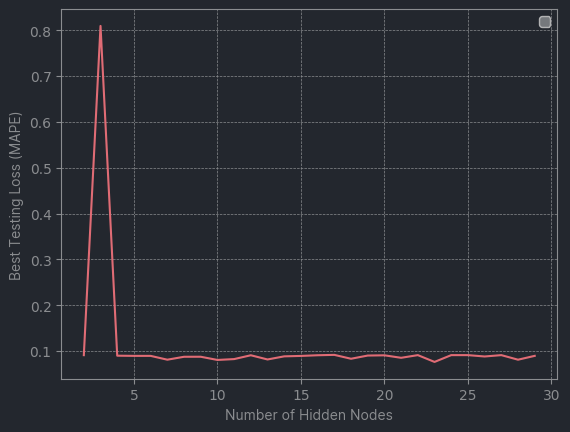

In [101]:
with open('finder_basic/finder_basic.pkl', 'rb') as input:
    finder_basic = pickle.load(input)

finder_basic.plot_result()

The plot above shows that above 6 hidden nodes, there is little benefit to increasing the number of hidden nodes.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


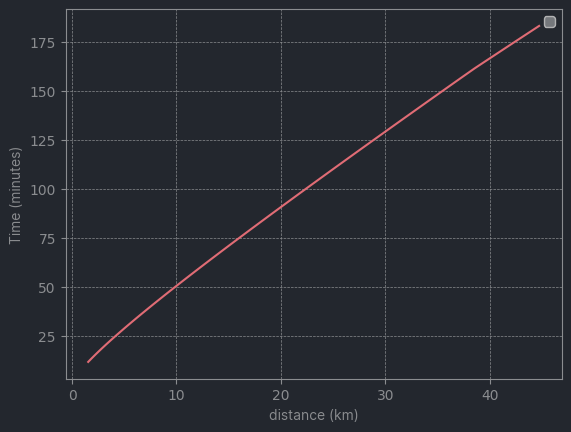

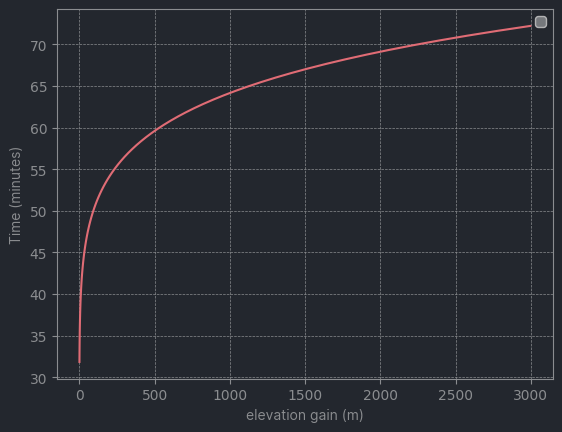

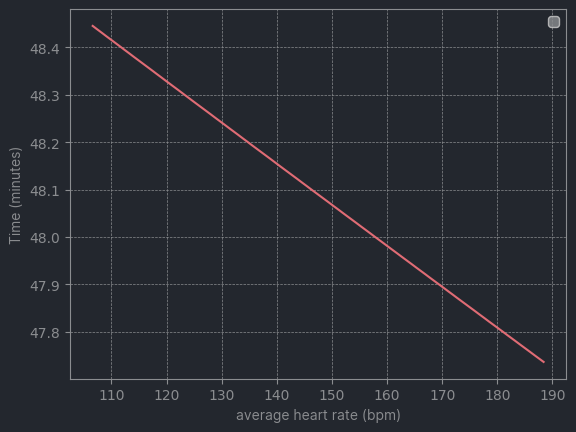

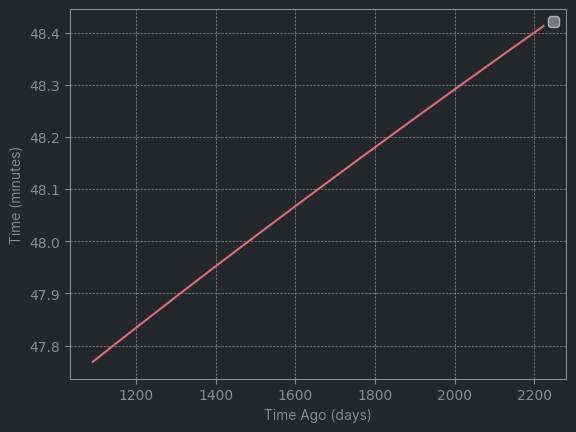

In [102]:
handler_path = 'finder_basic/handler_8hn.pkl'

with open(handler_path, 'rb') as file:
    handler = pickle.load(file)
    
handler.plot_relationships()

The relationship between heart-rate and time-ago can have sudden step changes in gradient with LeakyReLU. Therefore, I'll tweak the selection of activation functions to improve enable better continuity of the relationship.

In [103]:
from helpers.distance_running import ELU_NN

In [104]:
finder_ELU = find_hn_epochs(
    model_class=ELU_NN, 
    start_hn=2, 
    stop_hn=30, 
    dataobject=data19023831
    )

finder_ELU.find(save_best=True, target_folder='finder_ELU')

with open('finder_ELU/finder_ELU.pkl', 'wb') as output:
    pickle.dump(finder_ELU, output, pickle.HIGHEST_PROTOCOL)

100.0% complete | Estimated time remaining = 0.00 minutes


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


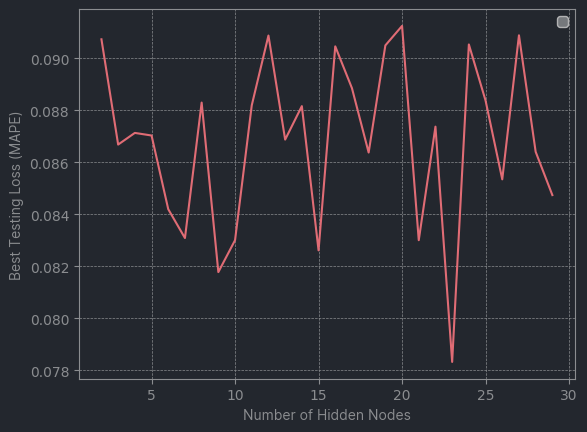

In [105]:
with open('finder_ELU/finder_ELU.pkl', 'rb') as input:
    finder_ELU = pickle.load(input)

finder_ELU.plot_result()

Like before, there is no benefit in increasing the number of hidden nodes to above 6.

In [106]:
handler_path = 'finder_ELU/handler_6hn.pkl'

with open(handler_path, 'rb') as file:
    base_handler = pickle.load(file)
    
print(f'Model was trained with {base_handler.total_epochs} epochs')

Model was trained with 3 epochs


In [107]:
print(f'Best MAPE achieved on test data: {base_handler.testing_losses_mape[-1]}')

Best MAPE achieved on test data: 0.08419593423604965


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


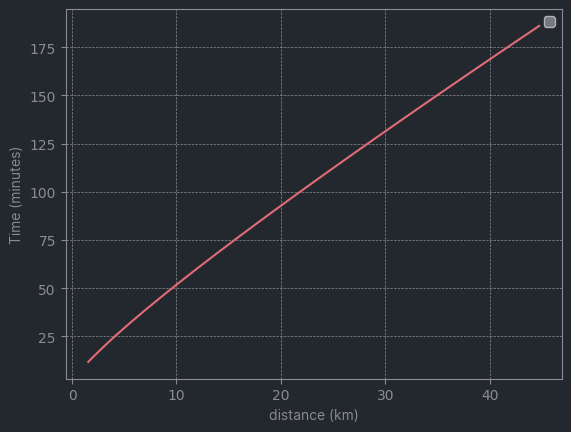

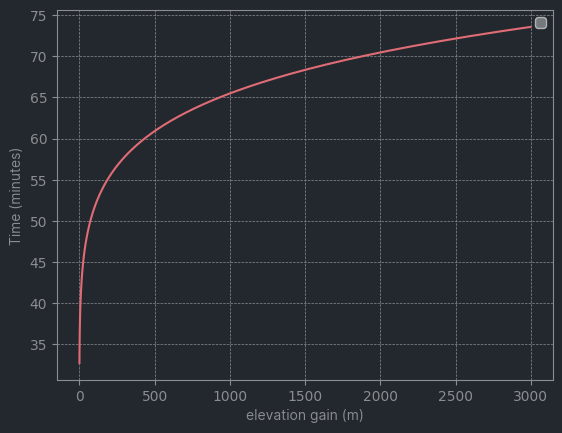

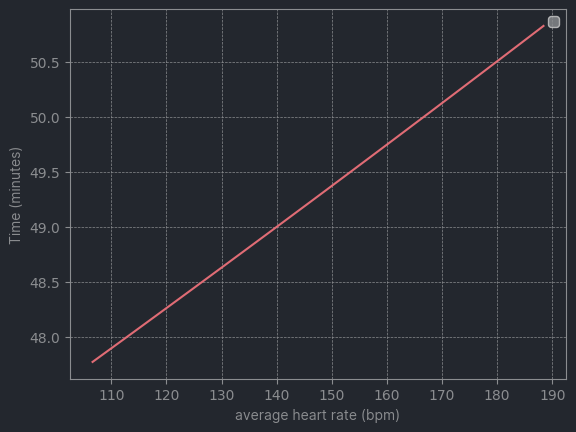

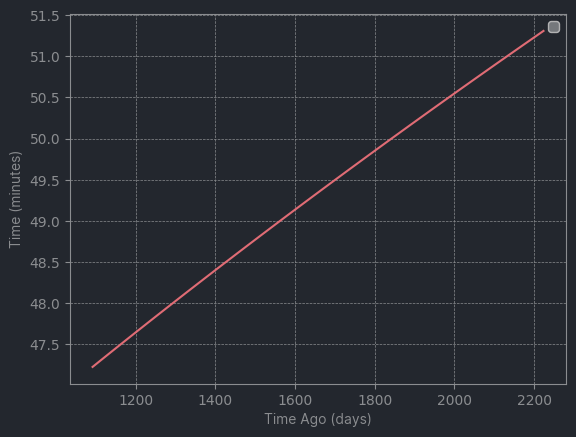

In [108]:
base_handler.plot_relationships()

In [109]:
base_handler.plot_training_results()

The training results show that the model was not overtrained and that the testing results have converged to a minimum. Therefore, I will use 2 hidden nodes and 128 epochs for my base models.

# **Testing out Transfer Learning**

In [110]:
from helpers.distance_running import prepare_new_data

In [111]:
import copy

# load the base model
handler_path = 'finder_ELU/handler_6hn.pkl'

with open(handler_path, 'rb') as file:
    base_handler = pickle.load(file)

base_model = copy.deepcopy(base_handler.model)

data_newath = athlete_data(athletes = [18223349], device = "cpu")

new_x_train_tensor, new_x_test_tensor, new_y_train_tensor, new_y_test_tensor = prepare_new_data(data19023831, data_newath)

# get the baseline error
base_mape = mape_actualtime(pred_tensor = base_model(new_x_test_tensor),
                            true_tensor = new_y_test_tensor,
                            dataobject = data19023831).detach().numpy().item()

print(f'Baseline MAPE: {base_mape}')
print(f'The new athlete has {len(data_newath.X)} data points')

Baseline MAPE: 0.11938003450632095
The new athlete has 408 data points


The baseline MAPE is already very good.

The advantage of transfer learning is the ability to fit a pretrained model to a new, very small, dataset. Therefore, I'll compare the performance when there is different number of data points available for these fine tuning methods.

In [112]:
from time import time
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

data_fraction_list = np.linspace(0.015,1.0,15)

transfer_mape_list = []
retrained_mape_list = []
scratch_mape_list = []

mape_list = pd.DataFrame(columns = ["type", "athlete", "mape"])

epochs = 100
patience = 15
count=0
st = time()
ets = []

# load in the data

for ath in train_athletes[2:10]:

    data_newath = athlete_data(athletes = [ath], device = "cpu")

    all_x_train_tensor, all_x_test_tensor, all_y_train_tensor, all_y_test_tensor = prepare_new_data(data19023831, data_newath)

    raw_x_train, raw_x_test, raw_y_train, raw_y_test = train_test_split(data_newath.X[INPUT_COLS].values, data_newath.y.values.reshape(-1,1), test_size = 0.1, random_state=30)

    for data_fraction in data_fraction_list:
        
        # vary the number of provided training data points
        reduced_x_train_tensor = all_x_train_tensor[:int(round((data_fraction)*len(all_x_train_tensor)))]
        reduced_y_train_tensor = all_y_train_tensor[:int(round((data_fraction)*len(all_y_train_tensor)))]

        # batch size 10% of the training set, but max size 20, min size 5
        batch_size = int(np.clip(round(0.1*len(reduced_x_train_tensor)), a_min=5, a_max=20))

        # Transfer Learning

        # create a copy to tune with transfer-learning
        transfer_model = copy.deepcopy(base_model)

        # freeze model parameters to prevent backpropagation
        for param in transfer_model.parameters():
            param.requires_grad = False

        # Reset the last layer
        # transfer_model.output = nn.Linear(
        #     transfer_model.output.in_features,
        #     transfer_model.output.out_features
        #     )
        
        # Unfreeze the last layer
        for param in transfer_model.output.parameters():
            param.requires_grad = True

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(transfer_model.output.parameters(), lr=0.001)

        transfer_handler = model_handler(model = transfer_model, 
                                        dataobject = data_newath)

        transfer_handler.train(epochs = epochs,
                            batch_size = batch_size,
                            x_train_tensor = reduced_x_train_tensor,
                            y_train_tensor = reduced_y_train_tensor,
                            x_test_tensor  = new_x_test_tensor,
                            y_test_tensor  = new_y_test_tensor,
                            EarlyStopping_Patience=patience)
        transfer_mape = mape_actualtime(pred_tensor = transfer_handler.model(new_x_test_tensor),
                                        true_tensor = new_y_test_tensor,
                                        dataobject = data19023831).detach().numpy().item()
        
        # transfer_mape_list.append(transfer_mape)
        df = pd.DataFrame({
            "type": ["transfer"], 
            "athlete": [ath], 
            "data size": [int(round((data_fraction)*len(reduced_x_train_tensor)))], 
            "mape": [transfer_mape]
        })
        mape_list = pd.concat([mape_list, df])

        # Re-training all parameters (fewer epochs to prevent overfit)
        retrained_model = copy.deepcopy(base_model)

        retrained_handler = model_handler(model = retrained_model, 
                                        dataobject = data_newath)
        retrained_handler.train(epochs = epochs,
                                batch_size = batch_size,
                                x_train_tensor = reduced_x_train_tensor,
                                y_train_tensor = reduced_y_train_tensor,
                                x_test_tensor  = new_x_test_tensor,
                                y_test_tensor  = new_y_test_tensor,
                                EarlyStopping_Patience=patience)
        retrained_mape = mape_actualtime(pred_tensor = retrained_handler.model(new_x_test_tensor),
                                        true_tensor = new_y_test_tensor,
                                        dataobject = data19023831).detach().numpy().item()
        
        # retrained_mape_list.append(retrained_mape)
        df = pd.DataFrame({
            "type": ["retrain"], 
            "athlete": [ath], 
            "data size": [int(round((data_fraction)*len(reduced_x_train_tensor)))], 
            "mape": [retrained_mape]
        })
        mape_list = pd.concat([mape_list, df])

        # Create a model from scratch (randomised initial weights/biases)
        scratch_handler = model_handler(model = ELU_NN(6),
                                        dataobject=data_newath)

        x_raw = raw_x_train.copy()
        x_yjpt = PowerTransformer(method='yeo-johnson')
        x_transformed = x_yjpt.fit_transform(x_raw)
        x_transformed[:,2] = x_raw[:,2]
        x_scaler = MinMaxScaler(feature_range=(0,1))
        x_scaled_train = x_scaler.fit_transform(x_transformed)

        y_raw = raw_y_train.copy()
        y_yjpt = PowerTransformer(method='yeo-johnson')
        y_transformed = y_yjpt.fit_transform(y_raw)
        y_scaler = MinMaxScaler(feature_range=(0,1))
        y_scaled_train = y_scaler.fit_transform(y_transformed)

        x_scaled_test = x_scaler.transform(x_yjpt.transform(raw_x_test))
        y_scaled_test = y_scaler.transform(y_yjpt.transform(raw_y_test))

        x_train_tensor = torch.tensor(x_scaled_train).float().to('cpu')
        x_test_tensor = torch.tensor(x_scaled_test).float().to('cpu')
        y_train_tensor = torch.tensor(y_scaled_train).float().to('cpu')
        y_test_tensor = torch.tensor(y_scaled_test).float().to('cpu')

        reduced_x_train_tensor = x_train_tensor[:int(round((data_fraction)*len(x_train_tensor)))]
        reduced_y_train_tensor = y_train_tensor[:int(round((data_fraction)*len(y_train_tensor)))]

        scratch_handler.train(epochs = epochs,
                            batch_size = batch_size,
                            x_train_tensor = reduced_x_train_tensor,
                            y_train_tensor = reduced_y_train_tensor,
                            x_test_tensor  = x_test_tensor,
                            y_test_tensor  = y_test_tensor,
                            EarlyStopping_Patience=patience)

        pred_seconds = scratch_handler.model(x_test_tensor).detach().numpy()

        pred_seconds = y_yjpt.inverse_transform(y_scaler.inverse_transform(pred_seconds)).flatten()

        # pred_seconds = y_scaler.inverse_transform(pred_seconds).flatten()

        scratch_mape = sum(abs((pred_seconds-raw_y_test.flatten())/(raw_y_test.flatten())))/len(raw_y_test)

        # scratch_mape_list.append(scratch_mape)
        df = pd.DataFrame({
            "type": ["scratch"], 
            "athlete": [ath], 
            "data size": [int(round((data_fraction)*len(reduced_x_train_tensor)))], 
            "mape": [scratch_mape]
        })
        mape_list = pd.concat([mape_list, df])
        
        clear_output(wait=True)
        count += 1
        et = time()-st
        ets.append(et)
        et = np.mean(ets[-3:])
        pc = count/(len(data_fraction_list)*8)
        etr = et/pc * (1-pc)
        print(f'{pc*100:.1f}% complete | Estimated time remaining = {etr/60:.2f} minutes')

100.0% complete | Estimated time remaining = 0.00 minutes


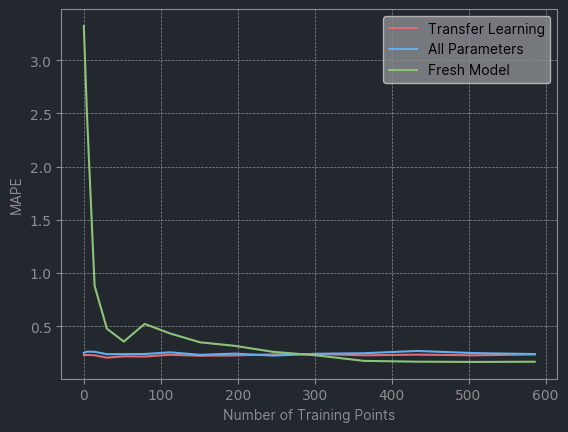

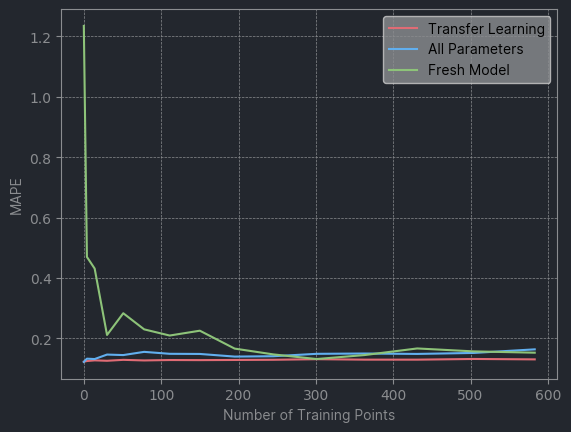

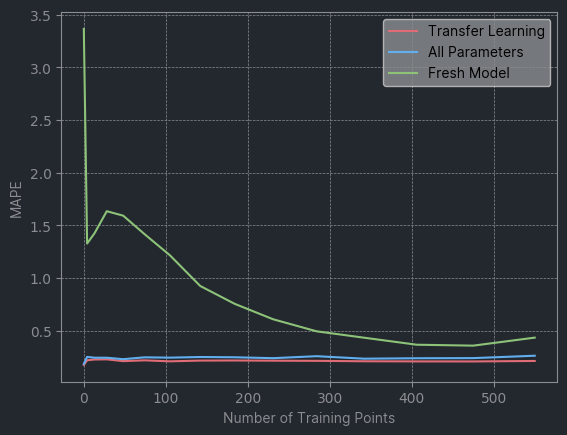

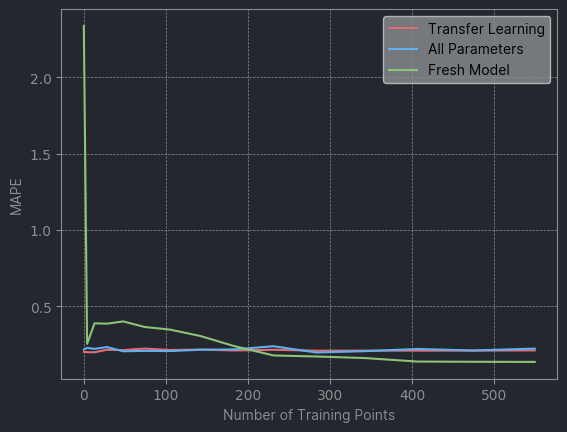

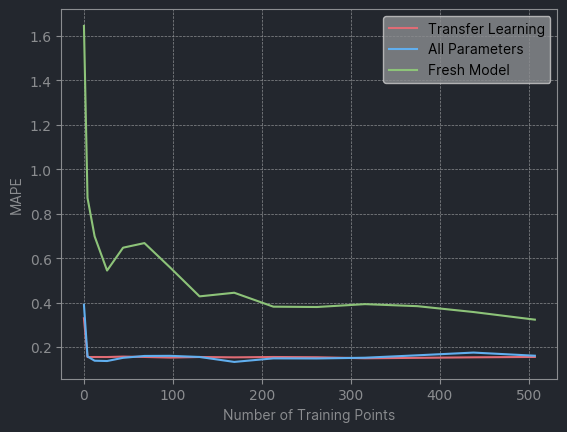

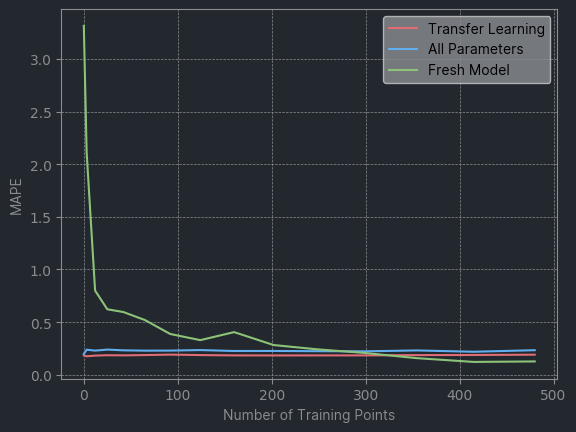

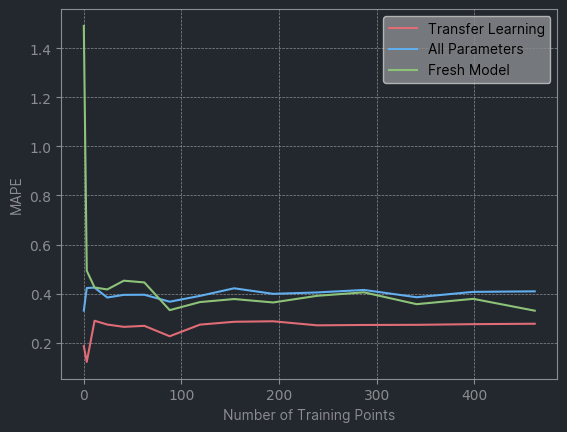

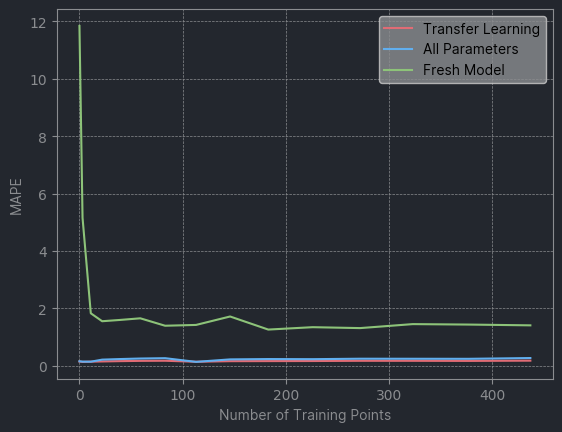

In [113]:
from helpers.my_plotting import my_xyline

for ath in mape_list['athlete'].unique():

    filtered_mape_list = mape_list[mape_list['athlete'] == ath]

    transfer_mape_list = filtered_mape_list[filtered_mape_list['type'] == 'transfer'].sort_values('data size').groupby('data size')['mape'].mean().values

    retrained_mape_list = filtered_mape_list[filtered_mape_list['type'] == 'retrain'].sort_values('data size').groupby('data size')['mape'].mean().values

    scratch_mape_list = filtered_mape_list[filtered_mape_list['type'] == 'scratch'].sort_values('data size').groupby('data size')['mape'].mean().values

    data_sizes = filtered_mape_list.sort_values('data size')['data size'].unique()

    my_xyline(x1 = data_sizes,
            y1 = transfer_mape_list,
            y1_label='Transfer Learning',
            x2 = data_sizes,
            y2 = retrained_mape_list,
            y2_label='All Parameters',
            x3 = data_sizes,
            y3 = scratch_mape_list,
            y3_label='Fresh Model',
            y_label='MAPE',
            x_label='Number of Training Points')

The general trend is that all-parameter fine-tuning and transfer learning both performing significantly better than creating a completely new model when there are fewer than several hundred new samples.

In most cases, fine tuning a base model achieved better loss even when there were several hundred new samples.

Transfer learning consistently performed slightly better than all-parameter fine-tuning.

# **Creating Base Models**

A base model and "model handler" will be created for each athlete in the training set. The *model handler* will contain the model itself, as well as the loss history, transformers and scalers.

When a new user wants to predict their race time, we'll find the pre-trained base model with the lowest loss on the new user's data. This base model will then be fine-tuned to the new user's data to predict their race time.

In [114]:
print(f'Number of athletes to train with: {len(train_athletes)}')
print(train_athletes)

Number of athletes to train with: 46
[19023831, 17639804, 23729907, 3573750, 10825360, 6367873, 20653961, 16378210, 2081128, 10446972, 18736169, 22835898, 5035018, 6215611, 7947798, 5688059, 11348733, 18223349, 5421161, 5151970, 3460571, 19741163, 5861500, 12021072, 25191153, 15515123, 11088529, 11284478, 3539760, 22843389, 14588097, 20136629, 2913078, 16021442, 22891135, 34669133, 1776170, 26367918, 21299972, 12701438, 14019837, 12740383, 34460713, 18042525, 22353493, 12642956]


In [115]:
import os

# move the first base model in to the folder

handler_path = 'finder_ELU/handler_6hn.pkl'

try:
    os.mkdir('base_models_complete')
except FileExistsError:
    pass

with open(handler_path, 'rb') as input:
    base_handler = pickle.load(input)

with open('base_models_complete/handler001.pkl', 'wb') as output:
    pickle.dump(base_handler, output, pickle.HIGHEST_PROTOCOL)

In [116]:
# create a JSON to keep track of which athletes have been included in which model/handler
import json 

handler_tracker = {
    'athletes_completed': [],
    'handler001.pkl': {
        'athlete': '[19023831]',
    }
}

with open('base_models_complete/handler_tracker_complete.json', 'w') as output:
    json.dump(handler_tracker, output)

This function will save a JSON to keep a record of the base models in ```base_models_complete\handler_tracker_complete.json```

In [117]:
from helpers.distance_running import update_handler_tracker

In [118]:
update_handler_tracker('complete')

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



{'athletes_completed': '[19023831, 23729907, 3573750, 10825360, 6367873, 20653961, 16378210, 2081128, 10446972, 18736169, 22835898, 5035018, 6215611, 7947798, 5688059, 11348733, 18223349, 5421161, 5151970, 3460571, 19741163, 5861500, 12021072, 25191153, 15515123, 11088529, 11284478, 3539760, 22843389, 14588097, 20136629, 2913078, 16021442, 22891135, 34669133, 1776170, 26367918, 21299972, 12701438, 14019837, 12740383, 34460713, 18042525, 22353493, 12642956]',
 'handler001.pkl': {'athlete': '[19023831]',
  'best_mape_test': 0.08419593423604965,
  'total_epochs': 3},
 'handler002.pkl': {'athlete': '[23729907]',
  'best_mape_test': 0.14925536513328552,
  'total_epochs': 512},
 'handler003.pkl': {'athlete': '[3573750]',
  'best_mape_test': 0.1506766974925995,
  'total_epochs': 72},
 'handler004.pkl': {'athlete': '[10825360]',
  'best_mape_test': 0.2149832546710968,
  'total_epochs': 512},
 'handler005.pkl': {'athlete': '[6367873]',
  'best_mape_test': 0.1386357992887497,
  'total_epochs': 2

Create base models with LeakyReLU activation functions:

In [119]:
# create a base model for each athlete in train_athletes

num = 0

st= time()
for ath in train_athletes[num:]:

    new_dataobject = athlete_data(athletes = [ath], device = "cpu")

    # create a new base model
    new_handler = model_handler(
        model = LeakyReLU_NN(6), 
        dataobject = new_dataobject
        ) 
    
    new_handler.train(
        epochs = 512, 
        batch_size = 20,
        save_best = True,
        save_path = f'base_models_LeakyReLU/handler{str(num).zfill(3)}.pkl',
        EarlyStopping_Patience=25,
        factor_duplications=0.1
    )

    num+=1

    handler_tracker = update_handler_tracker('LeakyReLU')

    clear_output(wait=True)
    et = time()-st
    pc = num/(len(train_athletes))
    etr = et/pc * (1-pc)
    print(f'{pc*100:.1f}% complete | Estimated time remaining = {etr/60:.2f} minutes')

100.0% complete | Estimated time remaining = 0.00 minutes


Create base models with ELU activation functions. These will be the base models we will use.

In [120]:
# create a base model for each athlete in train_athletes

num = 2

for ath in train_athletes[num:]:

    new_dataobject = athlete_data(athletes = [ath], device = "cpu")

    # create a new base model
    new_handler = model_handler(
        model = ELU_NN(6), 
        dataobject = new_dataobject
        ) 
    
    new_handler.train(
        epochs = 512, 
        batch_size = 20,
        save_best = True,
        save_path = f'base_models_complete/handler{str(num).zfill(3)}.pkl',
        EarlyStopping_Patience=25,
        factor_duplications=0.1
    )

    num+=1

    handler_tracker = update_handler_tracker('complete')

Epoch 001 | Average training loss: 0.13871 | Average testing loss: 0.00785
Epoch 002 | Average training loss: 0.02303 | Average testing loss: 0.00330
Epoch 003 | Average training loss: 0.01741 | Average testing loss: 0.00282
Epoch 004 | Average training loss: 0.01551 | Average testing loss: 0.00255
Epoch 005 | Average training loss: 0.01421 | Average testing loss: 0.00239
Epoch 006 | Average training loss: 0.01323 | Average testing loss: 0.00226
Epoch 007 | Average training loss: 0.01235 | Average testing loss: 0.00217
Epoch 008 | Average training loss: 0.01158 | Average testing loss: 0.00211
Epoch 009 | Average training loss: 0.01086 | Average testing loss: 0.00208
Epoch 010 | Average training loss: 0.01021 | Average testing loss: 0.00207
Epoch 011 | Average training loss: 0.00965 | Average testing loss: 0.00207
Epoch 012 | Average training loss: 0.00913 | Average testing loss: 0.00206
Epoch 013 | Average training loss: 0.00871 | Average testing loss: 0.00205
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.26412 | Average testing loss: 0.01343
Epoch 002 | Average training loss: 0.02903 | Average testing loss: 0.00432
Epoch 003 | Average training loss: 0.02039 | Average testing loss: 0.00282
Epoch 004 | Average training loss: 0.01786 | Average testing loss: 0.00246
Epoch 005 | Average training loss: 0.01612 | Average testing loss: 0.00228
Epoch 006 | Average training loss: 0.01468 | Average testing loss: 0.00215
Epoch 007 | Average training loss: 0.01356 | Average testing loss: 0.00204
Epoch 008 | Average training loss: 0.01264 | Average testing loss: 0.00188
Epoch 009 | Average training loss: 0.01185 | Average testing loss: 0.00175
Epoch 010 | Average training loss: 0.01117 | Average testing loss: 0.00166
Epoch 011 | Average training loss: 0.01058 | Average testing loss: 0.00159
Epoch 012 | Average training loss: 0.01003 | Average testing loss: 0.00155
Epoch 013 | Average training loss: 0.00952 | Average testing loss: 0.00152
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.15631 | Average testing loss: 0.09962
Epoch 002 | Average training loss: 0.04488 | Average testing loss: 0.03424
Epoch 003 | Average training loss: 0.03138 | Average testing loss: 0.01914
Epoch 004 | Average training loss: 0.02350 | Average testing loss: 0.01047
Epoch 005 | Average training loss: 0.01928 | Average testing loss: 0.00671
Epoch 006 | Average training loss: 0.01712 | Average testing loss: 0.00526
Epoch 007 | Average training loss: 0.01574 | Average testing loss: 0.00461
Epoch 008 | Average training loss: 0.01471 | Average testing loss: 0.00421
Epoch 009 | Average training loss: 0.01390 | Average testing loss: 0.00392
Epoch 010 | Average training loss: 0.01321 | Average testing loss: 0.00372
Epoch 011 | Average training loss: 0.01263 | Average testing loss: 0.00355
Epoch 012 | Average training loss: 0.01213 | Average testing loss: 0.00340
Epoch 013 | Average training loss: 0.01173 | Average testing loss: 0.00331
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.08720 | Average testing loss: 0.00418
Epoch 002 | Average training loss: 0.01848 | Average testing loss: 0.00342
Epoch 003 | Average training loss: 0.01553 | Average testing loss: 0.00287
Epoch 004 | Average training loss: 0.01362 | Average testing loss: 0.00246
Epoch 005 | Average training loss: 0.01227 | Average testing loss: 0.00224
Epoch 006 | Average training loss: 0.01119 | Average testing loss: 0.00211
Epoch 007 | Average training loss: 0.01022 | Average testing loss: 0.00204
Epoch 008 | Average training loss: 0.00939 | Average testing loss: 0.00200
Epoch 009 | Average training loss: 0.00877 | Average testing loss: 0.00192
Epoch 010 | Average training loss: 0.00828 | Average testing loss: 0.00187
Epoch 011 | Average training loss: 0.00788 | Average testing loss: 0.00182
Epoch 012 | Average training loss: 0.00755 | Average testing loss: 0.00178
Epoch 013 | Average training loss: 0.00736 | Average testing loss: 0.00175
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.09979 | Average testing loss: 0.03063
Epoch 002 | Average training loss: 0.02740 | Average testing loss: 0.00946
Epoch 003 | Average training loss: 0.01843 | Average testing loss: 0.00512
Epoch 004 | Average training loss: 0.01549 | Average testing loss: 0.00427
Epoch 005 | Average training loss: 0.01384 | Average testing loss: 0.00390
Epoch 006 | Average training loss: 0.01265 | Average testing loss: 0.00368
Epoch 007 | Average training loss: 0.01172 | Average testing loss: 0.00353
Epoch 008 | Average training loss: 0.01090 | Average testing loss: 0.00340
Epoch 009 | Average training loss: 0.01017 | Average testing loss: 0.00332
Epoch 010 | Average training loss: 0.00959 | Average testing loss: 0.00327
Epoch 011 | Average training loss: 0.00907 | Average testing loss: 0.00320
Epoch 012 | Average training loss: 0.00862 | Average testing loss: 0.00316
Epoch 013 | Average training loss: 0.00814 | Average testing loss: 0.00311
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.13655 | Average testing loss: 0.05170
Epoch 002 | Average training loss: 0.04109 | Average testing loss: 0.02074
Epoch 003 | Average training loss: 0.02573 | Average testing loss: 0.00907
Epoch 004 | Average training loss: 0.01977 | Average testing loss: 0.00582
Epoch 005 | Average training loss: 0.01740 | Average testing loss: 0.00448
Epoch 006 | Average training loss: 0.01587 | Average testing loss: 0.00363
Epoch 007 | Average training loss: 0.01461 | Average testing loss: 0.00306
Epoch 008 | Average training loss: 0.01354 | Average testing loss: 0.00265
Epoch 009 | Average training loss: 0.01266 | Average testing loss: 0.00238
Epoch 010 | Average training loss: 0.01189 | Average testing loss: 0.00219
Epoch 011 | Average training loss: 0.01125 | Average testing loss: 0.00207
Epoch 012 | Average training loss: 0.01072 | Average testing loss: 0.00199
Epoch 013 | Average training loss: 0.01025 | Average testing loss: 0.00194
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.45699 | Average testing loss: 0.18155
Epoch 002 | Average training loss: 0.11492 | Average testing loss: 0.01057
Epoch 003 | Average training loss: 0.03816 | Average testing loss: 0.00551
Epoch 004 | Average training loss: 0.03112 | Average testing loss: 0.00361
Epoch 005 | Average training loss: 0.02600 | Average testing loss: 0.00235
Epoch 006 | Average training loss: 0.02243 | Average testing loss: 0.00166
Epoch 007 | Average training loss: 0.02015 | Average testing loss: 0.00134
Epoch 008 | Average training loss: 0.01875 | Average testing loss: 0.00122
Epoch 009 | Average training loss: 0.01780 | Average testing loss: 0.00117
Epoch 010 | Average training loss: 0.01709 | Average testing loss: 0.00115
Epoch 011 | Average training loss: 0.01652 | Average testing loss: 0.00114
Epoch 012 | Average training loss: 0.01601 | Average testing loss: 0.00114
Epoch 013 | Average training loss: 0.01554 | Average testing loss: 0.00113
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.53301 | Average testing loss: 0.39082
Epoch 002 | Average training loss: 0.29820 | Average testing loss: 0.17273
Epoch 003 | Average training loss: 0.12157 | Average testing loss: 0.03493
Epoch 004 | Average training loss: 0.04330 | Average testing loss: 0.00793
Epoch 005 | Average training loss: 0.03415 | Average testing loss: 0.00725
Epoch 006 | Average training loss: 0.03208 | Average testing loss: 0.00676
Epoch 007 | Average training loss: 0.03020 | Average testing loss: 0.00622
Epoch 008 | Average training loss: 0.02846 | Average testing loss: 0.00576
Epoch 009 | Average training loss: 0.02689 | Average testing loss: 0.00536
Epoch 010 | Average training loss: 0.02549 | Average testing loss: 0.00502
Epoch 011 | Average training loss: 0.02427 | Average testing loss: 0.00473
Epoch 012 | Average training loss: 0.02319 | Average testing loss: 0.00448
Epoch 013 | Average training loss: 0.02225 | Average testing loss: 0.00428
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.15411 | Average testing loss: 0.02427
Epoch 002 | Average training loss: 0.04046 | Average testing loss: 0.00901
Epoch 003 | Average training loss: 0.02521 | Average testing loss: 0.00637
Epoch 004 | Average training loss: 0.02168 | Average testing loss: 0.00570
Epoch 005 | Average training loss: 0.02004 | Average testing loss: 0.00519
Epoch 006 | Average training loss: 0.01885 | Average testing loss: 0.00482
Epoch 007 | Average training loss: 0.01795 | Average testing loss: 0.00460
Epoch 008 | Average training loss: 0.01724 | Average testing loss: 0.00449
Epoch 009 | Average training loss: 0.01665 | Average testing loss: 0.00441
Epoch 010 | Average training loss: 0.01613 | Average testing loss: 0.00435
Epoch 011 | Average training loss: 0.01564 | Average testing loss: 0.00428
Epoch 012 | Average training loss: 0.01520 | Average testing loss: 0.00422
Epoch 013 | Average training loss: 0.01481 | Average testing loss: 0.00419
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.24483 | Average testing loss: 0.06212
Epoch 002 | Average training loss: 0.06733 | Average testing loss: 0.01309
Epoch 003 | Average training loss: 0.04565 | Average testing loss: 0.00924
Epoch 004 | Average training loss: 0.03283 | Average testing loss: 0.00653
Epoch 005 | Average training loss: 0.02458 | Average testing loss: 0.00462
Epoch 006 | Average training loss: 0.02008 | Average testing loss: 0.00330
Epoch 007 | Average training loss: 0.01749 | Average testing loss: 0.00246
Epoch 008 | Average training loss: 0.01585 | Average testing loss: 0.00199
Epoch 009 | Average training loss: 0.01466 | Average testing loss: 0.00171
Epoch 010 | Average training loss: 0.01375 | Average testing loss: 0.00153
Epoch 011 | Average training loss: 0.01306 | Average testing loss: 0.00140
Epoch 012 | Average training loss: 0.01250 | Average testing loss: 0.00133
Epoch 013 | Average training loss: 0.01201 | Average testing loss: 0.00128
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.44643 | Average testing loss: 0.07323
Epoch 002 | Average training loss: 0.06519 | Average testing loss: 0.00951
Epoch 003 | Average training loss: 0.03366 | Average testing loss: 0.00616
Epoch 004 | Average training loss: 0.02657 | Average testing loss: 0.00428
Epoch 005 | Average training loss: 0.02235 | Average testing loss: 0.00317
Epoch 006 | Average training loss: 0.01998 | Average testing loss: 0.00255
Epoch 007 | Average training loss: 0.01851 | Average testing loss: 0.00217
Epoch 008 | Average training loss: 0.01743 | Average testing loss: 0.00192
Epoch 009 | Average training loss: 0.01651 | Average testing loss: 0.00174
Epoch 010 | Average training loss: 0.01569 | Average testing loss: 0.00161
Epoch 011 | Average training loss: 0.01498 | Average testing loss: 0.00151
Epoch 012 | Average training loss: 0.01434 | Average testing loss: 0.00143
Epoch 013 | Average training loss: 0.01378 | Average testing loss: 0.00137
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.10295 | Average testing loss: 0.03877
Epoch 002 | Average training loss: 0.03524 | Average testing loss: 0.01944
Epoch 003 | Average training loss: 0.02466 | Average testing loss: 0.00948
Epoch 004 | Average training loss: 0.01916 | Average testing loss: 0.00535
Epoch 005 | Average training loss: 0.01654 | Average testing loss: 0.00406
Epoch 006 | Average training loss: 0.01513 | Average testing loss: 0.00355
Epoch 007 | Average training loss: 0.01413 | Average testing loss: 0.00328
Epoch 008 | Average training loss: 0.01331 | Average testing loss: 0.00313
Epoch 009 | Average training loss: 0.01267 | Average testing loss: 0.00304
Epoch 010 | Average training loss: 0.01209 | Average testing loss: 0.00299
Epoch 011 | Average training loss: 0.01154 | Average testing loss: 0.00295
Epoch 012 | Average training loss: 0.01102 | Average testing loss: 0.00290
Epoch 013 | Average training loss: 0.01053 | Average testing loss: 0.00287
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.09431 | Average testing loss: 0.04302
Epoch 002 | Average training loss: 0.03421 | Average testing loss: 0.02258
Epoch 003 | Average training loss: 0.02687 | Average testing loss: 0.01458
Epoch 004 | Average training loss: 0.02224 | Average testing loss: 0.01007
Epoch 005 | Average training loss: 0.01922 | Average testing loss: 0.00760
Epoch 006 | Average training loss: 0.01721 | Average testing loss: 0.00629
Epoch 007 | Average training loss: 0.01572 | Average testing loss: 0.00550
Epoch 008 | Average training loss: 0.01456 | Average testing loss: 0.00504
Epoch 009 | Average training loss: 0.01362 | Average testing loss: 0.00466
Epoch 010 | Average training loss: 0.01282 | Average testing loss: 0.00438
Epoch 011 | Average training loss: 0.01215 | Average testing loss: 0.00418
Epoch 012 | Average training loss: 0.01156 | Average testing loss: 0.00402
Epoch 013 | Average training loss: 0.01105 | Average testing loss: 0.00387
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.36314 | Average testing loss: 0.32595
Epoch 002 | Average training loss: 0.20282 | Average testing loss: 0.14942
Epoch 003 | Average training loss: 0.09648 | Average testing loss: 0.04692
Epoch 004 | Average training loss: 0.05603 | Average testing loss: 0.01861
Epoch 005 | Average training loss: 0.04626 | Average testing loss: 0.01411
Epoch 006 | Average training loss: 0.03998 | Average testing loss: 0.01155
Epoch 007 | Average training loss: 0.03463 | Average testing loss: 0.00907
Epoch 008 | Average training loss: 0.03015 | Average testing loss: 0.00718
Epoch 009 | Average training loss: 0.02648 | Average testing loss: 0.00579
Epoch 010 | Average training loss: 0.02362 | Average testing loss: 0.00475
Epoch 011 | Average training loss: 0.02149 | Average testing loss: 0.00403
Epoch 012 | Average training loss: 0.01992 | Average testing loss: 0.00354
Epoch 013 | Average training loss: 0.01880 | Average testing loss: 0.00324
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.22250 | Average testing loss: 0.13030
Epoch 002 | Average training loss: 0.07640 | Average testing loss: 0.02099
Epoch 003 | Average training loss: 0.04560 | Average testing loss: 0.01161
Epoch 004 | Average training loss: 0.03332 | Average testing loss: 0.00808
Epoch 005 | Average training loss: 0.02547 | Average testing loss: 0.00699
Epoch 006 | Average training loss: 0.02148 | Average testing loss: 0.00647
Epoch 007 | Average training loss: 0.01946 | Average testing loss: 0.00589
Epoch 008 | Average training loss: 0.01818 | Average testing loss: 0.00533
Epoch 009 | Average training loss: 0.01716 | Average testing loss: 0.00482
Epoch 010 | Average training loss: 0.01630 | Average testing loss: 0.00441
Epoch 011 | Average training loss: 0.01555 | Average testing loss: 0.00408
Epoch 012 | Average training loss: 0.01491 | Average testing loss: 0.00381
Epoch 013 | Average training loss: 0.01436 | Average testing loss: 0.00354
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.27571 | Average testing loss: 0.19725
Epoch 002 | Average training loss: 0.07161 | Average testing loss: 0.02821
Epoch 003 | Average training loss: 0.03585 | Average testing loss: 0.01631
Epoch 004 | Average training loss: 0.03066 | Average testing loss: 0.01214
Epoch 005 | Average training loss: 0.02637 | Average testing loss: 0.00880
Epoch 006 | Average training loss: 0.02306 | Average testing loss: 0.00639
Epoch 007 | Average training loss: 0.02072 | Average testing loss: 0.00485
Epoch 008 | Average training loss: 0.01907 | Average testing loss: 0.00389
Epoch 009 | Average training loss: 0.01786 | Average testing loss: 0.00330
Epoch 010 | Average training loss: 0.01691 | Average testing loss: 0.00294
Epoch 011 | Average training loss: 0.01617 | Average testing loss: 0.00273
Epoch 012 | Average training loss: 0.01557 | Average testing loss: 0.00262
Epoch 013 | Average training loss: 0.01508 | Average testing loss: 0.00254
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.19990 | Average testing loss: 0.05011
Epoch 002 | Average training loss: 0.05190 | Average testing loss: 0.01355
Epoch 003 | Average training loss: 0.03425 | Average testing loss: 0.00779
Epoch 004 | Average training loss: 0.02517 | Average testing loss: 0.00512
Epoch 005 | Average training loss: 0.02091 | Average testing loss: 0.00419
Epoch 006 | Average training loss: 0.01897 | Average testing loss: 0.00379
Epoch 007 | Average training loss: 0.01775 | Average testing loss: 0.00353
Epoch 008 | Average training loss: 0.01682 | Average testing loss: 0.00331
Epoch 009 | Average training loss: 0.01607 | Average testing loss: 0.00314
Epoch 010 | Average training loss: 0.01544 | Average testing loss: 0.00299
Epoch 011 | Average training loss: 0.01487 | Average testing loss: 0.00287
Epoch 012 | Average training loss: 0.01434 | Average testing loss: 0.00276
Epoch 013 | Average training loss: 0.01385 | Average testing loss: 0.00267
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.42466 | Average testing loss: 0.28606
Epoch 002 | Average training loss: 0.20861 | Average testing loss: 0.10009
Epoch 003 | Average training loss: 0.08550 | Average testing loss: 0.02465
Epoch 004 | Average training loss: 0.05277 | Average testing loss: 0.01346
Epoch 005 | Average training loss: 0.04171 | Average testing loss: 0.00938
Epoch 006 | Average training loss: 0.03332 | Average testing loss: 0.00621
Epoch 007 | Average training loss: 0.02718 | Average testing loss: 0.00429
Epoch 008 | Average training loss: 0.02332 | Average testing loss: 0.00328
Epoch 009 | Average training loss: 0.02121 | Average testing loss: 0.00283
Epoch 010 | Average training loss: 0.02003 | Average testing loss: 0.00265
Epoch 011 | Average training loss: 0.01926 | Average testing loss: 0.00257
Epoch 012 | Average training loss: 0.01867 | Average testing loss: 0.00253
Epoch 013 | Average training loss: 0.01816 | Average testing loss: 0.00251
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.19346 | Average testing loss: 0.14251
Epoch 002 | Average training loss: 0.07423 | Average testing loss: 0.04074
Epoch 003 | Average training loss: 0.04927 | Average testing loss: 0.02641
Epoch 004 | Average training loss: 0.04170 | Average testing loss: 0.02076
Epoch 005 | Average training loss: 0.03561 | Average testing loss: 0.01636
Epoch 006 | Average training loss: 0.03053 | Average testing loss: 0.01301
Epoch 007 | Average training loss: 0.02665 | Average testing loss: 0.01060
Epoch 008 | Average training loss: 0.02401 | Average testing loss: 0.00898
Epoch 009 | Average training loss: 0.02225 | Average testing loss: 0.00787
Epoch 010 | Average training loss: 0.02104 | Average testing loss: 0.00707
Epoch 011 | Average training loss: 0.02013 | Average testing loss: 0.00643
Epoch 012 | Average training loss: 0.01940 | Average testing loss: 0.00595
Epoch 013 | Average training loss: 0.01879 | Average testing loss: 0.00557
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.82237 | Average testing loss: 0.46245
Epoch 002 | Average training loss: 0.47973 | Average testing loss: 0.21484
Epoch 003 | Average training loss: 0.19882 | Average testing loss: 0.04564
Epoch 004 | Average training loss: 0.05614 | Average testing loss: 0.00623
Epoch 005 | Average training loss: 0.03447 | Average testing loss: 0.00659
Epoch 006 | Average training loss: 0.03318 | Average testing loss: 0.00561
Epoch 007 | Average training loss: 0.03197 | Average testing loss: 0.00502
Epoch 008 | Average training loss: 0.03079 | Average testing loss: 0.00450
Epoch 009 | Average training loss: 0.02966 | Average testing loss: 0.00403
Epoch 010 | Average training loss: 0.02863 | Average testing loss: 0.00363
Epoch 011 | Average training loss: 0.02766 | Average testing loss: 0.00329
Epoch 012 | Average training loss: 0.02674 | Average testing loss: 0.00300
Epoch 013 | Average training loss: 0.02588 | Average testing loss: 0.00275
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.10541 | Average testing loss: 0.11133
Epoch 002 | Average training loss: 0.04756 | Average testing loss: 0.05507
Epoch 003 | Average training loss: 0.03777 | Average testing loss: 0.03681
Epoch 004 | Average training loss: 0.03091 | Average testing loss: 0.02475
Epoch 005 | Average training loss: 0.02613 | Average testing loss: 0.01748
Epoch 006 | Average training loss: 0.02302 | Average testing loss: 0.01349
Epoch 007 | Average training loss: 0.02084 | Average testing loss: 0.01125
Epoch 008 | Average training loss: 0.01919 | Average testing loss: 0.00986
Epoch 009 | Average training loss: 0.01789 | Average testing loss: 0.00893
Epoch 010 | Average training loss: 0.01682 | Average testing loss: 0.00826
Epoch 011 | Average training loss: 0.01592 | Average testing loss: 0.00776
Epoch 012 | Average training loss: 0.01513 | Average testing loss: 0.00741
Epoch 013 | Average training loss: 0.01448 | Average testing loss: 0.00715
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.54923 | Average testing loss: 0.29084
Epoch 002 | Average training loss: 0.31879 | Average testing loss: 0.12694
Epoch 003 | Average training loss: 0.13839 | Average testing loss: 0.02766
Epoch 004 | Average training loss: 0.05569 | Average testing loss: 0.01499
Epoch 005 | Average training loss: 0.04305 | Average testing loss: 0.01130
Epoch 006 | Average training loss: 0.03718 | Average testing loss: 0.00776
Epoch 007 | Average training loss: 0.03236 | Average testing loss: 0.00548
Epoch 008 | Average training loss: 0.02874 | Average testing loss: 0.00398
Epoch 009 | Average training loss: 0.02612 | Average testing loss: 0.00311
Epoch 010 | Average training loss: 0.02430 | Average testing loss: 0.00267
Epoch 011 | Average training loss: 0.02302 | Average testing loss: 0.00246
Epoch 012 | Average training loss: 0.02209 | Average testing loss: 0.00237
Epoch 013 | Average training loss: 0.02138 | Average testing loss: 0.00231
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.62057 | Average testing loss: 0.39261
Epoch 002 | Average training loss: 0.39846 | Average testing loss: 0.21626
Epoch 003 | Average training loss: 0.21478 | Average testing loss: 0.08148
Epoch 004 | Average training loss: 0.09130 | Average testing loss: 0.01530
Epoch 005 | Average training loss: 0.04586 | Average testing loss: 0.00521
Epoch 006 | Average training loss: 0.03833 | Average testing loss: 0.00454
Epoch 007 | Average training loss: 0.03486 | Average testing loss: 0.00390
Epoch 008 | Average training loss: 0.03177 | Average testing loss: 0.00347
Epoch 009 | Average training loss: 0.02907 | Average testing loss: 0.00317
Epoch 010 | Average training loss: 0.02684 | Average testing loss: 0.00299
Epoch 011 | Average training loss: 0.02505 | Average testing loss: 0.00288
Epoch 012 | Average training loss: 0.02367 | Average testing loss: 0.00282
Epoch 013 | Average training loss: 0.02259 | Average testing loss: 0.00278
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.71360 | Average testing loss: 0.44487
Epoch 002 | Average training loss: 0.44112 | Average testing loss: 0.23403
Epoch 003 | Average training loss: 0.21202 | Average testing loss: 0.06995
Epoch 004 | Average training loss: 0.06654 | Average testing loss: 0.00695
Epoch 005 | Average training loss: 0.03193 | Average testing loss: 0.00503
Epoch 006 | Average training loss: 0.02998 | Average testing loss: 0.00426
Epoch 007 | Average training loss: 0.02864 | Average testing loss: 0.00384
Epoch 008 | Average training loss: 0.02738 | Average testing loss: 0.00349
Epoch 009 | Average training loss: 0.02621 | Average testing loss: 0.00318
Epoch 010 | Average training loss: 0.02514 | Average testing loss: 0.00292
Epoch 011 | Average training loss: 0.02416 | Average testing loss: 0.00271
Epoch 012 | Average training loss: 0.02328 | Average testing loss: 0.00254
Epoch 013 | Average training loss: 0.02249 | Average testing loss: 0.00240
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.82835 | Average testing loss: 0.51511
Epoch 002 | Average training loss: 0.46269 | Average testing loss: 0.24726
Epoch 003 | Average training loss: 0.18272 | Average testing loss: 0.07153
Epoch 004 | Average training loss: 0.05426 | Average testing loss: 0.01989
Epoch 005 | Average training loss: 0.03575 | Average testing loss: 0.01555
Epoch 006 | Average training loss: 0.03421 | Average testing loss: 0.01488
Epoch 007 | Average training loss: 0.03294 | Average testing loss: 0.01390
Epoch 008 | Average training loss: 0.03174 | Average testing loss: 0.01294
Epoch 009 | Average training loss: 0.03063 | Average testing loss: 0.01209
Epoch 010 | Average training loss: 0.02960 | Average testing loss: 0.01131
Epoch 011 | Average training loss: 0.02865 | Average testing loss: 0.01059
Epoch 012 | Average training loss: 0.02776 | Average testing loss: 0.00993
Epoch 013 | Average training loss: 0.02693 | Average testing loss: 0.00932
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.44545 | Average testing loss: 0.31780
Epoch 002 | Average training loss: 0.24891 | Average testing loss: 0.13287
Epoch 003 | Average training loss: 0.11252 | Average testing loss: 0.02728
Epoch 004 | Average training loss: 0.05602 | Average testing loss: 0.00805
Epoch 005 | Average training loss: 0.03835 | Average testing loss: 0.00444
Epoch 006 | Average training loss: 0.02841 | Average testing loss: 0.00259
Epoch 007 | Average training loss: 0.02325 | Average testing loss: 0.00196
Epoch 008 | Average training loss: 0.02097 | Average testing loss: 0.00179
Epoch 009 | Average training loss: 0.01990 | Average testing loss: 0.00174
Epoch 010 | Average training loss: 0.01926 | Average testing loss: 0.00171
Epoch 011 | Average training loss: 0.01877 | Average testing loss: 0.00167
Epoch 012 | Average training loss: 0.01832 | Average testing loss: 0.00164
Epoch 013 | Average training loss: 0.01789 | Average testing loss: 0.00161
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.16226 | Average testing loss: 0.12393
Epoch 002 | Average training loss: 0.05343 | Average testing loss: 0.03488
Epoch 003 | Average training loss: 0.03701 | Average testing loss: 0.02305
Epoch 004 | Average training loss: 0.03188 | Average testing loss: 0.01707
Epoch 005 | Average training loss: 0.02795 | Average testing loss: 0.01266
Epoch 006 | Average training loss: 0.02497 | Average testing loss: 0.00949
Epoch 007 | Average training loss: 0.02275 | Average testing loss: 0.00738
Epoch 008 | Average training loss: 0.02103 | Average testing loss: 0.00598
Epoch 009 | Average training loss: 0.01971 | Average testing loss: 0.00510
Epoch 010 | Average training loss: 0.01868 | Average testing loss: 0.00452
Epoch 011 | Average training loss: 0.01789 | Average testing loss: 0.00416
Epoch 012 | Average training loss: 0.01722 | Average testing loss: 0.00390
Epoch 013 | Average training loss: 0.01665 | Average testing loss: 0.00373
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.79872 | Average testing loss: 0.45551
Epoch 002 | Average training loss: 0.42107 | Average testing loss: 0.19180
Epoch 003 | Average training loss: 0.13907 | Average testing loss: 0.03082
Epoch 004 | Average training loss: 0.03438 | Average testing loss: 0.00944
Epoch 005 | Average training loss: 0.02770 | Average testing loss: 0.00855
Epoch 006 | Average training loss: 0.02664 | Average testing loss: 0.00770
Epoch 007 | Average training loss: 0.02559 | Average testing loss: 0.00689
Epoch 008 | Average training loss: 0.02463 | Average testing loss: 0.00617
Epoch 009 | Average training loss: 0.02373 | Average testing loss: 0.00551
Epoch 010 | Average training loss: 0.02289 | Average testing loss: 0.00494
Epoch 011 | Average training loss: 0.02212 | Average testing loss: 0.00445
Epoch 012 | Average training loss: 0.02142 | Average testing loss: 0.00403
Epoch 013 | Average training loss: 0.02080 | Average testing loss: 0.00368
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.21964 | Average testing loss: 0.21828
Epoch 002 | Average training loss: 0.13294 | Average testing loss: 0.12219
Epoch 003 | Average training loss: 0.08380 | Average testing loss: 0.06461
Epoch 004 | Average training loss: 0.06045 | Average testing loss: 0.03565
Epoch 005 | Average training loss: 0.05153 | Average testing loss: 0.02536
Epoch 006 | Average training loss: 0.04724 | Average testing loss: 0.02187
Epoch 007 | Average training loss: 0.04376 | Average testing loss: 0.01958
Epoch 008 | Average training loss: 0.04048 | Average testing loss: 0.01742
Epoch 009 | Average training loss: 0.03722 | Average testing loss: 0.01528
Epoch 010 | Average training loss: 0.03397 | Average testing loss: 0.01326
Epoch 011 | Average training loss: 0.03082 | Average testing loss: 0.01138
Epoch 012 | Average training loss: 0.02779 | Average testing loss: 0.00971
Epoch 013 | Average training loss: 0.02499 | Average testing loss: 0.00818
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.82888 | Average testing loss: 0.42237
Epoch 002 | Average training loss: 0.47543 | Average testing loss: 0.19343
Epoch 003 | Average training loss: 0.18793 | Average testing loss: 0.03903
Epoch 004 | Average training loss: 0.05053 | Average testing loss: 0.00842
Epoch 005 | Average training loss: 0.03175 | Average testing loss: 0.00800
Epoch 006 | Average training loss: 0.02966 | Average testing loss: 0.00663
Epoch 007 | Average training loss: 0.02783 | Average testing loss: 0.00578
Epoch 008 | Average training loss: 0.02626 | Average testing loss: 0.00513
Epoch 009 | Average training loss: 0.02491 | Average testing loss: 0.00464
Epoch 010 | Average training loss: 0.02377 | Average testing loss: 0.00430
Epoch 011 | Average training loss: 0.02281 | Average testing loss: 0.00407
Epoch 012 | Average training loss: 0.02202 | Average testing loss: 0.00393
Epoch 013 | Average training loss: 0.02137 | Average testing loss: 0.00384
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.17606 | Average testing loss: 0.06013
Epoch 002 | Average training loss: 0.05253 | Average testing loss: 0.01490
Epoch 003 | Average training loss: 0.04451 | Average testing loss: 0.01075
Epoch 004 | Average training loss: 0.04142 | Average testing loss: 0.00897
Epoch 005 | Average training loss: 0.03946 | Average testing loss: 0.00829
Epoch 006 | Average training loss: 0.03802 | Average testing loss: 0.00806
Epoch 007 | Average training loss: 0.03688 | Average testing loss: 0.00810
Epoch 008 | Average training loss: 0.03599 | Average testing loss: 0.00820
Epoch 009 | Average training loss: 0.03522 | Average testing loss: 0.00833
Epoch 010 | Average training loss: 0.03453 | Average testing loss: 0.00847
Epoch 011 | Average training loss: 0.03391 | Average testing loss: 0.00863
Epoch 012 | Average training loss: 0.03333 | Average testing loss: 0.00876
Epoch 013 | Average training loss: 0.03279 | Average testing loss: 0.00892
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.40313 | Average testing loss: 0.34597
Epoch 002 | Average training loss: 0.31856 | Average testing loss: 0.26256
Epoch 003 | Average training loss: 0.24920 | Average testing loss: 0.19181
Epoch 004 | Average training loss: 0.19064 | Average testing loss: 0.13161
Epoch 005 | Average training loss: 0.14218 | Average testing loss: 0.08221
Epoch 006 | Average training loss: 0.10430 | Average testing loss: 0.04574
Epoch 007 | Average training loss: 0.07840 | Average testing loss: 0.02402
Epoch 008 | Average training loss: 0.06400 | Average testing loss: 0.01452
Epoch 009 | Average training loss: 0.05692 | Average testing loss: 0.01118
Epoch 010 | Average training loss: 0.05255 | Average testing loss: 0.00967
Epoch 011 | Average training loss: 0.04890 | Average testing loss: 0.00865
Epoch 012 | Average training loss: 0.04556 | Average testing loss: 0.00777
Epoch 013 | Average training loss: 0.04242 | Average testing loss: 0.00697
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.48911 | Average testing loss: 0.31996
Epoch 002 | Average training loss: 0.29837 | Average testing loss: 0.16334
Epoch 003 | Average training loss: 0.15669 | Average testing loss: 0.06064
Epoch 004 | Average training loss: 0.08458 | Average testing loss: 0.02350
Epoch 005 | Average training loss: 0.06427 | Average testing loss: 0.01767
Epoch 006 | Average training loss: 0.05627 | Average testing loss: 0.01616
Epoch 007 | Average training loss: 0.04952 | Average testing loss: 0.01481
Epoch 008 | Average training loss: 0.04337 | Average testing loss: 0.01350
Epoch 009 | Average training loss: 0.03780 | Average testing loss: 0.01238
Epoch 010 | Average training loss: 0.03292 | Average testing loss: 0.01138
Epoch 011 | Average training loss: 0.02883 | Average testing loss: 0.01054
Epoch 012 | Average training loss: 0.02562 | Average testing loss: 0.00985
Epoch 013 | Average training loss: 0.02321 | Average testing loss: 0.00930
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.40622 | Average testing loss: 0.29192
Epoch 002 | Average training loss: 0.24051 | Average testing loss: 0.14076
Epoch 003 | Average training loss: 0.11743 | Average testing loss: 0.04576
Epoch 004 | Average training loss: 0.05435 | Average testing loss: 0.01602
Epoch 005 | Average training loss: 0.03879 | Average testing loss: 0.01289
Epoch 006 | Average training loss: 0.03433 | Average testing loss: 0.01114
Epoch 007 | Average training loss: 0.03090 | Average testing loss: 0.00973
Epoch 008 | Average training loss: 0.02803 | Average testing loss: 0.00858
Epoch 009 | Average training loss: 0.02569 | Average testing loss: 0.00770
Epoch 010 | Average training loss: 0.02382 | Average testing loss: 0.00703
Epoch 011 | Average training loss: 0.02236 | Average testing loss: 0.00655
Epoch 012 | Average training loss: 0.02122 | Average testing loss: 0.00620
Epoch 013 | Average training loss: 0.02036 | Average testing loss: 0.00597
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.41739 | Average testing loss: 0.33114
Epoch 002 | Average training loss: 0.30601 | Average testing loss: 0.22018
Epoch 003 | Average training loss: 0.21083 | Average testing loss: 0.12648
Epoch 004 | Average training loss: 0.13524 | Average testing loss: 0.05662
Epoch 005 | Average training loss: 0.08479 | Average testing loss: 0.01817
Epoch 006 | Average training loss: 0.06080 | Average testing loss: 0.00668
Epoch 007 | Average training loss: 0.05102 | Average testing loss: 0.00460
Epoch 008 | Average training loss: 0.04425 | Average testing loss: 0.00399
Epoch 009 | Average training loss: 0.03847 | Average testing loss: 0.00356
Epoch 010 | Average training loss: 0.03356 | Average testing loss: 0.00317
Epoch 011 | Average training loss: 0.02955 | Average testing loss: 0.00297
Epoch 012 | Average training loss: 0.02643 | Average testing loss: 0.00294
Epoch 013 | Average training loss: 0.02411 | Average testing loss: 0.00300
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.51052 | Average testing loss: 0.41192
Epoch 002 | Average training loss: 0.34782 | Average testing loss: 0.25668
Epoch 003 | Average training loss: 0.21360 | Average testing loss: 0.12872
Epoch 004 | Average training loss: 0.11144 | Average testing loss: 0.04193
Epoch 005 | Average training loss: 0.05816 | Average testing loss: 0.01222
Epoch 006 | Average training loss: 0.04525 | Average testing loss: 0.00835
Epoch 007 | Average training loss: 0.04059 | Average testing loss: 0.00712
Epoch 008 | Average training loss: 0.03627 | Average testing loss: 0.00621
Epoch 009 | Average training loss: 0.03266 | Average testing loss: 0.00548
Epoch 010 | Average training loss: 0.02976 | Average testing loss: 0.00505
Epoch 011 | Average training loss: 0.02750 | Average testing loss: 0.00485
Epoch 012 | Average training loss: 0.02574 | Average testing loss: 0.00478
Epoch 013 | Average training loss: 0.02439 | Average testing loss: 0.00478
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.56023 | Average testing loss: 0.34681
Epoch 002 | Average training loss: 0.45813 | Average testing loss: 0.27110
Epoch 003 | Average training loss: 0.37035 | Average testing loss: 0.20551
Epoch 004 | Average training loss: 0.29137 | Average testing loss: 0.14833
Epoch 005 | Average training loss: 0.22007 | Average testing loss: 0.10001
Epoch 006 | Average training loss: 0.15770 | Average testing loss: 0.06351
Epoch 007 | Average training loss: 0.10849 | Average testing loss: 0.04271
Epoch 008 | Average training loss: 0.07676 | Average testing loss: 0.03742
Epoch 009 | Average training loss: 0.06172 | Average testing loss: 0.04038
Epoch 010 | Average training loss: 0.05649 | Average testing loss: 0.04291
Epoch 011 | Average training loss: 0.05422 | Average testing loss: 0.04245
Epoch 012 | Average training loss: 0.05232 | Average testing loss: 0.04065
Epoch 013 | Average training loss: 0.05049 | Average testing loss: 0.03889
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.70238 | Average testing loss: 0.63478
Epoch 002 | Average training loss: 0.60119 | Average testing loss: 0.53764
Epoch 003 | Average training loss: 0.50742 | Average testing loss: 0.44597
Epoch 004 | Average training loss: 0.41888 | Average testing loss: 0.35847
Epoch 005 | Average training loss: 0.33655 | Average testing loss: 0.27703
Epoch 006 | Average training loss: 0.26158 | Average testing loss: 0.20248
Epoch 007 | Average training loss: 0.19503 | Average testing loss: 0.13692
Epoch 008 | Average training loss: 0.13957 | Average testing loss: 0.08397
Epoch 009 | Average training loss: 0.09842 | Average testing loss: 0.04674
Epoch 010 | Average training loss: 0.07278 | Average testing loss: 0.02517
Epoch 011 | Average training loss: 0.06011 | Average testing loss: 0.01529
Epoch 012 | Average training loss: 0.05509 | Average testing loss: 0.01161
Epoch 013 | Average training loss: 0.05293 | Average testing loss: 0.01032
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.54250 | Average testing loss: 0.40666
Epoch 002 | Average training loss: 0.42600 | Average testing loss: 0.30019
Epoch 003 | Average training loss: 0.31974 | Average testing loss: 0.20316
Epoch 004 | Average training loss: 0.22530 | Average testing loss: 0.12066
Epoch 005 | Average training loss: 0.14730 | Average testing loss: 0.05793
Epoch 006 | Average training loss: 0.09155 | Average testing loss: 0.02148
Epoch 007 | Average training loss: 0.06165 | Average testing loss: 0.00919
Epoch 008 | Average training loss: 0.04988 | Average testing loss: 0.00718
Epoch 009 | Average training loss: 0.04400 | Average testing loss: 0.00608
Epoch 010 | Average training loss: 0.03921 | Average testing loss: 0.00493
Epoch 011 | Average training loss: 0.03512 | Average testing loss: 0.00404
Epoch 012 | Average training loss: 0.03164 | Average testing loss: 0.00336
Epoch 013 | Average training loss: 0.02872 | Average testing loss: 0.00286
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.30178 | Average testing loss: 0.35849
Epoch 002 | Average training loss: 0.21881 | Average testing loss: 0.25488
Epoch 003 | Average training loss: 0.15466 | Average testing loss: 0.16953
Epoch 004 | Average training loss: 0.10632 | Average testing loss: 0.10289
Epoch 005 | Average training loss: 0.07385 | Average testing loss: 0.05756
Epoch 006 | Average training loss: 0.05624 | Average testing loss: 0.03369
Epoch 007 | Average training loss: 0.04808 | Average testing loss: 0.02378
Epoch 008 | Average training loss: 0.04315 | Average testing loss: 0.01952
Epoch 009 | Average training loss: 0.03907 | Average testing loss: 0.01670
Epoch 010 | Average training loss: 0.03541 | Average testing loss: 0.01411
Epoch 011 | Average training loss: 0.03212 | Average testing loss: 0.01174
Epoch 012 | Average training loss: 0.02922 | Average testing loss: 0.00974
Epoch 013 | Average training loss: 0.02674 | Average testing loss: 0.00817
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.48465 | Average testing loss: 0.38639
Epoch 002 | Average training loss: 0.36106 | Average testing loss: 0.26944
Epoch 003 | Average training loss: 0.24924 | Average testing loss: 0.16876
Epoch 004 | Average training loss: 0.15953 | Average testing loss: 0.09522
Epoch 005 | Average training loss: 0.10023 | Average testing loss: 0.05563
Epoch 006 | Average training loss: 0.07229 | Average testing loss: 0.04241
Epoch 007 | Average training loss: 0.06050 | Average testing loss: 0.03734
Epoch 008 | Average training loss: 0.05177 | Average testing loss: 0.03353
Epoch 009 | Average training loss: 0.04413 | Average testing loss: 0.03032
Epoch 010 | Average training loss: 0.03773 | Average testing loss: 0.02767
Epoch 011 | Average training loss: 0.03262 | Average testing loss: 0.02567
Epoch 012 | Average training loss: 0.02878 | Average testing loss: 0.02429
Epoch 013 | Average training loss: 0.02603 | Average testing loss: 0.02342
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.33551 | Average testing loss: 0.30290
Epoch 002 | Average training loss: 0.23849 | Average testing loss: 0.19517
Epoch 003 | Average training loss: 0.16265 | Average testing loss: 0.11148
Epoch 004 | Average training loss: 0.11116 | Average testing loss: 0.05843
Epoch 005 | Average training loss: 0.08403 | Average testing loss: 0.03393
Epoch 006 | Average training loss: 0.07132 | Average testing loss: 0.02431
Epoch 007 | Average training loss: 0.06216 | Average testing loss: 0.01889
Epoch 008 | Average training loss: 0.05341 | Average testing loss: 0.01429
Epoch 009 | Average training loss: 0.04519 | Average testing loss: 0.01019
Epoch 010 | Average training loss: 0.03794 | Average testing loss: 0.00699
Epoch 011 | Average training loss: 0.03210 | Average testing loss: 0.00478
Epoch 012 | Average training loss: 0.02780 | Average testing loss: 0.00344
Epoch 013 | Average training loss: 0.02488 | Average testing loss: 0.00270
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.53532 | Average testing loss: 0.28164
Epoch 002 | Average training loss: 0.24810 | Average testing loss: 0.07267
Epoch 003 | Average training loss: 0.07711 | Average testing loss: 0.02456
Epoch 004 | Average training loss: 0.04863 | Average testing loss: 0.02223
Epoch 005 | Average training loss: 0.04431 | Average testing loss: 0.01883
Epoch 006 | Average training loss: 0.04010 | Average testing loss: 0.01578
Epoch 007 | Average training loss: 0.03609 | Average testing loss: 0.01291
Epoch 008 | Average training loss: 0.03243 | Average testing loss: 0.01036
Epoch 009 | Average training loss: 0.02920 | Average testing loss: 0.00818
Epoch 010 | Average training loss: 0.02645 | Average testing loss: 0.00641
Epoch 011 | Average training loss: 0.02423 | Average testing loss: 0.00508
Epoch 012 | Average training loss: 0.02251 | Average testing loss: 0.00413
Epoch 013 | Average training loss: 0.02119 | Average testing loss: 0.00348
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Epoch 001 | Average training loss: 0.71995 | Average testing loss: 0.50276
Epoch 002 | Average training loss: 0.51526 | Average testing loss: 0.33470
Epoch 003 | Average training loss: 0.33052 | Average testing loss: 0.18726
Epoch 004 | Average training loss: 0.17761 | Average testing loss: 0.07458
Epoch 005 | Average training loss: 0.07680 | Average testing loss: 0.01817
Epoch 006 | Average training loss: 0.03783 | Average testing loss: 0.00690
Epoch 007 | Average training loss: 0.03126 | Average testing loss: 0.00643
Epoch 008 | Average training loss: 0.02971 | Average testing loss: 0.00610
Epoch 009 | Average training loss: 0.02836 | Average testing loss: 0.00589
Epoch 010 | Average training loss: 0.02712 | Average testing loss: 0.00572
Epoch 011 | Average training loss: 0.02600 | Average testing loss: 0.00560
Epoch 012 | Average training loss: 0.02501 | Average testing loss: 0.00553
Epoch 013 | Average training loss: 0.02413 | Average testing loss: 0.00550
Epoch 014 | Average train

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Continue training for another 256 epochs

In [121]:
# continue training

target_folder = 'base_models_complete'

for filename in os.listdir(target_folder):

    if filename.endswith('.pkl'):
        with open(f'{target_folder}/{filename}', 'rb') as input:
            temp_handler = pickle.load(input)

        clear_output(wait=True)
        print(filename)

        temp_handler.train(
            epochs = 256,
            batch_size = 20,
            save_best = True,
            save_path = f'{target_folder}/{filename}'
        )

        handler_tracker = update_handler_tracker('complete')

handler045.pkl
Epoch 001 | Average training loss: 0.01415 | Average testing loss: 0.00289
Epoch 002 | Average training loss: 0.01374 | Average testing loss: 0.00276
Epoch 003 | Average training loss: 0.01348 | Average testing loss: 0.00259
Epoch 004 | Average training loss: 0.01324 | Average testing loss: 0.00258
Epoch 005 | Average training loss: 0.01307 | Average testing loss: 0.00259
Epoch 006 | Average training loss: 0.01291 | Average testing loss: 0.00261
Epoch 007 | Average training loss: 0.01275 | Average testing loss: 0.00265
Epoch 008 | Average training loss: 0.01260 | Average testing loss: 0.00269
Epoch 009 | Average training loss: 0.01244 | Average testing loss: 0.00272
Epoch 010 | Average training loss: 0.01229 | Average testing loss: 0.00276
Epoch 011 | Average training loss: 0.01213 | Average testing loss: 0.00279
Epoch 012 | Average training loss: 0.01198 | Average testing loss: 0.00282
Epoch 013 | Average training loss: 0.01183 | Average testing loss: 0.00285
Epoch 014 

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



Save a JSON to keep track of the base models

In [126]:
update_handler_tracker('complete');

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.

c:\Users\hobly\OneDrive\2_EverythingElse\ML-AI\Distance-Running-Predictions\helpers\distance_running.py:680: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



# **Race Time Predictions!**

In this final section, I will use my own Strava data to test out everything I've built.

The race time I will predict for is a parkrun that I ran on 24 June 2023. 

The distance was 5 km, and the actual time I ran was 22:40. The accuracy of my smart watch consistently records distances roughly 2% greater than the true distance. The distances in my Strava data will be recorded with this inaccuracy. Hence, I will predict for a distance of 1.02 greater than 5K. This course has no elevation gain. For a 5K race, one should target roughly 90% of their max heart rate. Therefore, I will set the heart rate to 180 BPM for the race time prediction. 

My strava data, in ```my_strava_activities.csv```, contains every run and activity I did up to and excluding 24 June 2023.

In [2]:
import pandas as pd

In [3]:
race_info = pd.DataFrame({
    'distance (m)': [5000*1.02],
    'elevation gain (m)': [0.0],	
    'average heart rate (bpm)': [180],	
    'timestamp': ['2023-06-24']
})

This function will create a DataFrame of the user data.

In [4]:
from helpers.distance_running import read_strava_csv

In [5]:
user_df = read_strava_csv('my_strava_activities.csv')

user_df.head()

,elapsed time (s),distance (m),elevation gain (m),average heart rate (bpm),timestamp
12,1642,4750.0,16.182610,156.674469,2023-03-19 08:59:22
13,308,1050.0,0.000000,169.287582,2023-03-19 09:42:14
14,3921,10550.0,20.871429,159.226257,2023-03-20 17:52:56
15,312,950.0,5.607100,176.368927,2023-03-22 19:05:31
16,384,1220.0,0.000000,151.118729,2023-03-22 19:13:41


This function will look through the base models, and return the model that produces the lowest loss on the new user data. It will also apply scaling and transformation to the new user data using the scalers and transformers that were fitted on the base model's base athlete data.

In [6]:
from helpers.distance_running import get_best_model

In [7]:
base_handler, x_train_tensor, x_test_tensor, y_train_tensor, y_test_tensor, x_race_tensor, y_race_tensor, result  = get_best_model(
    user_df, 
    race_info, 
    model_folder = 'base_models_complete')

This function will fine tune the base model using the new user data

In [8]:
from helpers.distance_running import user_finetune

In [9]:
ft_handler = user_finetune(
    base_handler, 
    x_train_tensor, 
    x_test_tensor, 
    y_train_tensor, 
    y_test_tensor,
    epochs = 1028,
    batch_size = 1,
    patience = 25
)

Epoch 001 | Average training loss: 0.01432 | Average testing loss: 0.00905
Epoch 002 | Average training loss: 0.01219 | Average testing loss: 0.01234
Epoch 003 | Average training loss: 0.01143 | Average testing loss: 0.01276
Epoch 004 | Average training loss: 0.01095 | Average testing loss: 0.01219
Epoch 005 | Average training loss: 0.01055 | Average testing loss: 0.01160
Epoch 006 | Average training loss: 0.01019 | Average testing loss: 0.01118
Epoch 007 | Average training loss: 0.00985 | Average testing loss: 0.01078
Epoch 008 | Average training loss: 0.00953 | Average testing loss: 0.01055
Epoch 009 | Average training loss: 0.00923 | Average testing loss: 0.01046
Epoch 010 | Average training loss: 0.00896 | Average testing loss: 0.01034
Epoch 011 | Average training loss: 0.00871 | Average testing loss: 0.01026
Epoch 012 | Average training loss: 0.00850 | Average testing loss: 0.01016
Epoch 013 | Average training loss: 0.00832 | Average testing loss: 0.01008
Epoch 014 | Average train

Below is a measure of the confidence of the prediction. It is the MAPE loss on the test dataset, where the test dataset comes from the new user data.

In [10]:
confidence = ft_handler.testing_losses_mape[-1]
print(f'Confidence: {(1-confidence)*100:.2f}%')

Confidence: 75.86%


Running the prediction:

In [11]:
prediction = ft_handler.predict(x_race_tensor, scaled = True)

time = prediction[0]

print(f'Predicted Race Time: {time}')
print(f'Upper: {time*(1+confidence)}, Lower: {time*(1-confidence)}')

Predicted Race Time: 21.969014485677082
Upper: 27.27226100108328, Lower: 16.665767970270885


## **Evaluating the Fine-Tuned Model**

In [17]:
from helpers.my_plotting import my_xyscatter, theme
import numpy as np
import matplotlib.pyplot as plt

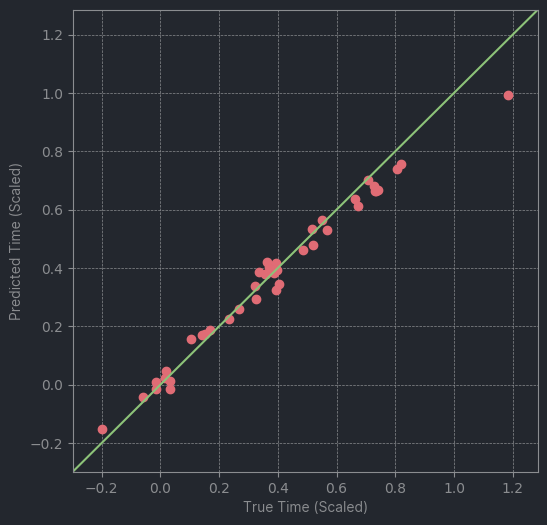

In [18]:

x = y_train_tensor.detach().numpy().flatten()
y = ft_handler.model(x_train_tensor.unsqueeze(1)).detach().numpy().flatten()
lims = (min(x.min(), y.min())-0.1, max(x.max(), y.max())+0.1)


fig, ax = my_xyscatter(x, y)
fig.set_size_inches(6, 6)
ax.plot(np.linspace(-2,2),np.linspace(-2,2), color=theme['green'])
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_ylabel('Predicted Time (Scaled)')
ax.set_xlabel('True Time (Scaled)')


plt.show()

The figure above shows that the fine tuned model has a good fit to the training data. However, it exhibits a tendency to underestimate race times, indicating potential bias in the predictions.

In [19]:
ft_handler.plot_training_results()

The loss curves above suggest that the fine tuned model has not overfit.

# **Conclusion**

The fine-tuned model predicted a race time of 21:58 for my 5K, using my Strava data. The actual time I achieved was 22:40. 

**The methodology achieved achieved an accuracy of 97%, and an error of 3%, in predicting race times using Strava user data.**